In [1]:
############ 导入各个package #############
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as itp
import scipy as sci
from astropy import wcs
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from astropy import cosmology
import matplotlib
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0

### 导入包含Ha ring sample和total sample数据的两个文件

In [2]:
ring_fits = fits.open(
    '2018-08-13-2.6kpc-radius-once-Ring clean sample_61bulge-density.fits')
all_fits = fits.open(
    '2018-08-13-2.6kpc-once-ALL-UV-Pipe3D-MPA-GZ-drpall-bulge-density.fits')

### 定义84个精选ring galaxies的质量、SFR、SSFR和大sample的质量、SFR、SSFR。

In [4]:
catalog_name = 'pipe3D'

if catalog_name == 'pipe3D':  
    ring_log_mass = ring_fits[1].data['log_mass']   # 来自pipe3D
    ring_log_SFR  = ring_fits[1].data['log_sfr_ha'] # 来自pipe3D
    ring_log_SSFR = ring_log_SFR - ring_log_mass 
    tot_log_mass  = all_fits[1].data['log_mass']    # 来自pipe3D
    tot_log_SFR   = all_fits[1].data['log_sfr_ha']  # 来自pipe3D
    tot_log_SSFR  = tot_log_SFR - tot_log_mass
elif catalog_name == 'MPA':
    ring_log_mass = ring_fits[1].data['MASS-MEDIAN'] # 来自MPA
    ring_log_SFR  = ring_fits[1].data['SFR-MEDIAN']  # 来自MPA
    ring_log_SSFR = ring_fits[1].data['SSFR-MEDIAN']
    tot_log_mass = all_fits[1].data['MASS-MEDIAN']   # 来自MPA
    tot_log_SFR  = all_fits[1].data['SFR-MEDIAN']    # 来自MPA
    tot_log_SSFR = all_fits[1].data['SSFR-MEDIAN']

### 导入自己处理出来的galaxy center (r = 1.3 kpc) 的谱线数据

In [5]:
rNII_Ha      = np.log10(ring_fits[1].data['core_nii']/ring_fits[1].data['core_ha'])
rOIII_Hb     = np.log10(ring_fits[1].data['core_oiii']/ring_fits[1].data['core_hb'])
rSII_Ha      = np.log10(ring_fits[1].data['core_sii']/ring_fits[1].data['core_ha'])
rew_ha       = ring_fits[1].data['core_EWha (AA)']  # diameter= 2.6 kpc
rew_ha[np.isnan(rew_ha)] = 0

tNII_Ha     = np.log10(all_fits[1].data['core_nii']/all_fits[1].data['core_ha'])
tOIII_Hb    = np.log10(all_fits[1].data['core_oiii']/all_fits[1].data['core_hb'])
tSII_Ha     = np.log10(all_fits[1].data['core_sii']/all_fits[1].data['core_ha'])
tew_ha      = all_fits[1].data['core_EWha (AA)']  # diameter= 2.6 kpc
tew_ha[np.isnan(tew_ha)] = 0

opBARmask   = (ring_fits[1].data['optical_bar'] == 1)
opRINGmask  = (ring_fits[1].data['optical_ring'] == 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


### 建立各种morphology mask。下面这块代码要run twice。

In [6]:
tGZ1mask         = ~np.isnan(all_fits[1].data['SPIRAL'])  ## GZ1mask为true的位置是有GZ1
tdisk_mask       = (all_fits[1].data['SPIRAL'] == 1)
telliptical_mask = (all_fits[1].data['ELLIPTICAL'] == 1)
tnelli_mask      = np.logical_and((all_fits[1].data['ELLIPTICAL'] != 1), (tGZ1mask))
tuncertain_mask  = (all_fits[1].data['UNCERTAIN'] == 1)
ttot_mask        = np.ones(all_fits[1].data['mangaid'].shape, dtype=bool)

print('disk mask total:', sum(tdisk_mask))
print('non-elliptical total:', sum(tnelli_mask))
print('elliptical total:', sum(telliptical_mask))
print('GZ1 mask total:', sum(tGZ1mask))
print('    ')


# 前缀为r的是ring的意思 #

rGZ1mask         = ~np.isnan(ring_fits[1].data['SPIRAL'])  ## GZ1mask为true的位置是有GZ1
rdisk_mask       = (ring_fits[1].data['SPIRAL'] == 1)
relliptical_mask = (ring_fits[1].data['ELLIPTICAL'] == 1)
rnelli_mask      = np.logical_and((ring_fits[1].data['ELLIPTICAL'] != 1), (rGZ1mask))
runcertain_mask  = (ring_fits[1].data['UNCERTAIN'] == 1)
rtot_mask        = np.ones(ring_fits[1].data['mangaid'].shape, dtype=bool)

print('ring disk mask total:', sum(rdisk_mask))
print('ring non-elliptical total:', sum(rnelli_mask))
print('ring elliptical total:', sum(relliptical_mask))
print('ring GZ1 mask total:', sum(rGZ1mask))

disk mask total: 784
non-elliptical total: 1778
elliptical total: 479
GZ1 mask total: 2257
    
ring disk mask total: 44
ring non-elliptical total: 67
ring elliptical total: 3
ring GZ1 mask total: 70


### 判断Ha ring sample和total sample里的AGN type，并画一个饼图。
该函数需要输入的是：`.fits`文件名，EW[Ha]数组，OIII/Hb数组，NII/Ha数组，OIII/Hb数组，SII/Ha数组，图片title，图片大小数组。

In [7]:
def AGN_diagnosis(fits, this_ew, y1, x1, y2, x2, suptitle, size):
    ############### 判断星系的类型，从两个图BPT & VO87 中分别判断 ###############
    RGmask = (this_ew <= 3)  # EW[Ha]小于3的是Retired Galaxy
    nonRGmask = (this_ew > 3)
    tot_mask  = np.ones(fits[1].data['mangaid'].shape, dtype=bool)
    
    #SF1=np.logical_and(np.logical_and(y<0.61/(x-0.05)+1.30, y<0.61/(x-0.47)+1.19),SNmask)
    SF1 = np.logical_and(
        nonRGmask,
        np.logical_and(
            x1 < 0,
            np.logical_and(y1 < 0.61 / (x1 - 0.05) + 1.30,
                           y1 < 0.61 / (x1 - 0.47) + 1.19)))
    #Composite=np.logical_and(np.logical_and(y>0.61/(x-0.05)+1.30, y<0.61/(x-0.47)+1.19),SNmask)
    Composite = np.logical_and(
        nonRGmask,
        np.logical_and(y1 > 0.61 / (x1 - 0.05) + 1.30,
                       y1 < 0.61 / (x1 - 0.47) + 1.19))
    #AGN1=np.logical_xor(np.logical_xor(SF1,SNmask),Composite)

    AGN1 = np.logical_and(
        nonRGmask,
        np.logical_xor(
            np.logical_xor(
                SF1, tot_mask),
            Composite))
    
    print("AGN1 number is %d" % sum(AGN1))
    print("SF1 number is %d" % sum(SF1))
    print("Composite number is %d" % sum(Composite))
    print("Retired number is %d" % sum(RGmask))
    print("Total number is %d" % sum(AGN1 + SF1 + Composite + RGmask))
    print('')

    SF2 = np.logical_and(
        nonRGmask, np.logical_and(y2 < 0.72 / (x2 - 0.32) + 1.30, x2 <= 0.1))
    LINER = np.logical_and(
        nonRGmask,
        np.logical_and(
            np.logical_xor(SF2, tot_mask),
            y2 <= 1.89 * x2 + 0.76))
    AGN2 = np.logical_and(
        nonRGmask,
        np.logical_and(
            np.logical_xor(SF2, tot_mask),
            y2 > 1.89 * x2 + 0.76))
    print("SF2 number is %d" % np.sum(SF2))
    print("LINER number is %d" % np.sum(LINER))
    print("Seyfert number is %d" % np.sum(AGN2))
    print("Retired number is %d" % sum(RGmask))
    print("Total number is %d" % sum(AGN2 + SF2 + LINER + RGmask))
    print('')
    
    fig = plt.figure(figsize=(size[0], size[1]))
    ############## 画图1 ###################
    ax1 = plt.subplot2grid((1, 2), (0, 0))
    labels = 'SF', 'Composite', 'AGN', 'Retired'
    sizes = [sum(SF1), sum(Composite), sum(AGN1), sum(RGmask)]
    explode = (0, 0, 0, 0)  #0.1表示将Hogs那一块凸显出来
    colors = 'lawngreen', 'skyblue', 'salmon', 'gray'
    plt.pie(
        sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=False,
        startangle=90,
        colors=colors)
    plt.title('BPT')
    
    ############## 画图2 ###################
    ax2 = plt.subplot2grid((1, 2), (0, 1))
    labels = 'SF', 'LINER', 'Seyfert', 'Retired'
    sizes = [sum(SF2), sum(LINER), sum(AGN2), sum(RGmask)]
    explode = (0, 0, 0, 0)  #0.1表示将Hogs那一块凸显出来
    colors = 'lawngreen', 'orange', 'r', 'gray'
    plt.pie(
        sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=False,
        startangle=90,
        colors=colors)
    plt.title('VO87')
    #plt.savefig('Fig1.eps', dpi=400)
    plt.suptitle(suptitle)
    plt.show()
    return AGN1, SF1, Composite, SF2, AGN2, LINER, RGmask, nonRGmask

AGN1 number is 10
SF1 number is 2
Composite number is 5
Retired number is 67
Total number is 84

SF2 number is 8
LINER number is 7
Seyfert number is 2
Retired number is 67
Total number is 84



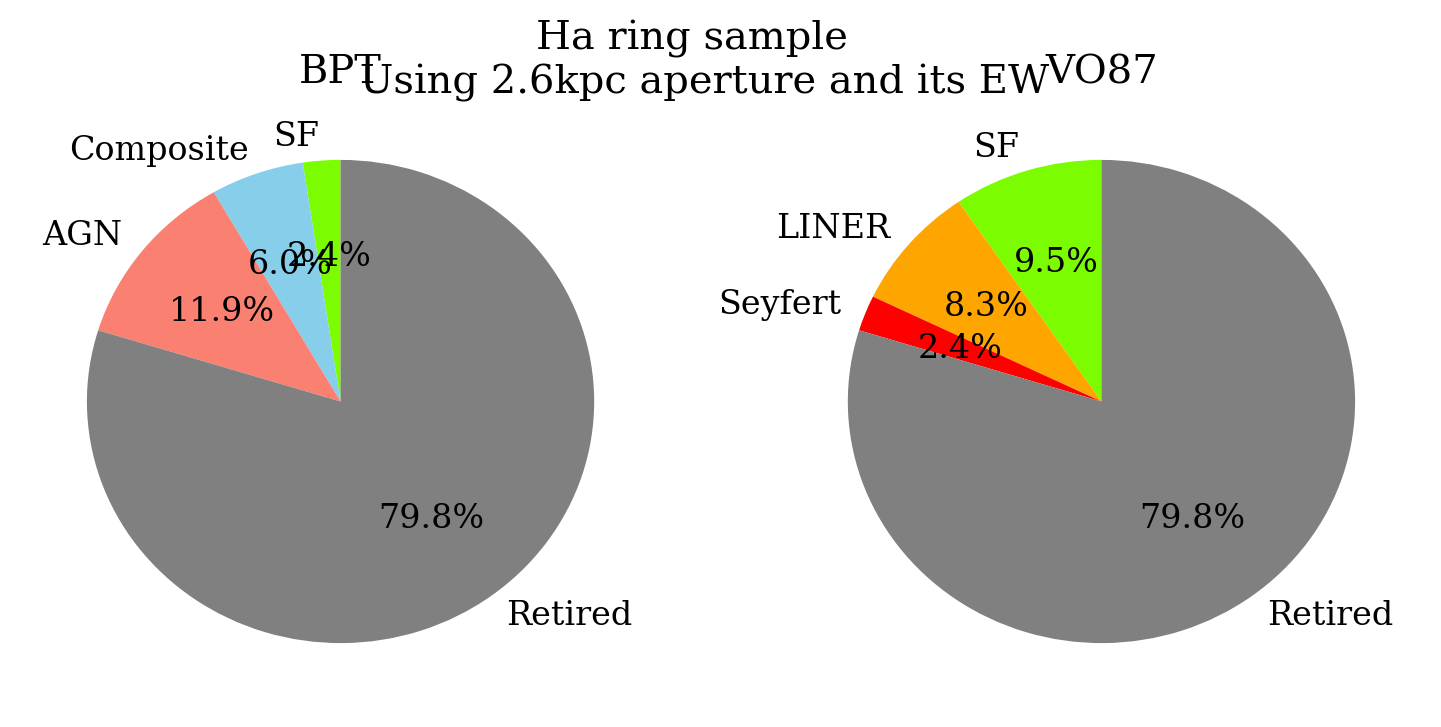

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launc

AGN1 number is 144
SF1 number is 1050
Composite number is 269
Retired number is 1241
Total number is 2704

SF2 number is 1256
LINER number is 154
Seyfert number is 51
Retired number is 1241
Total number is 2702



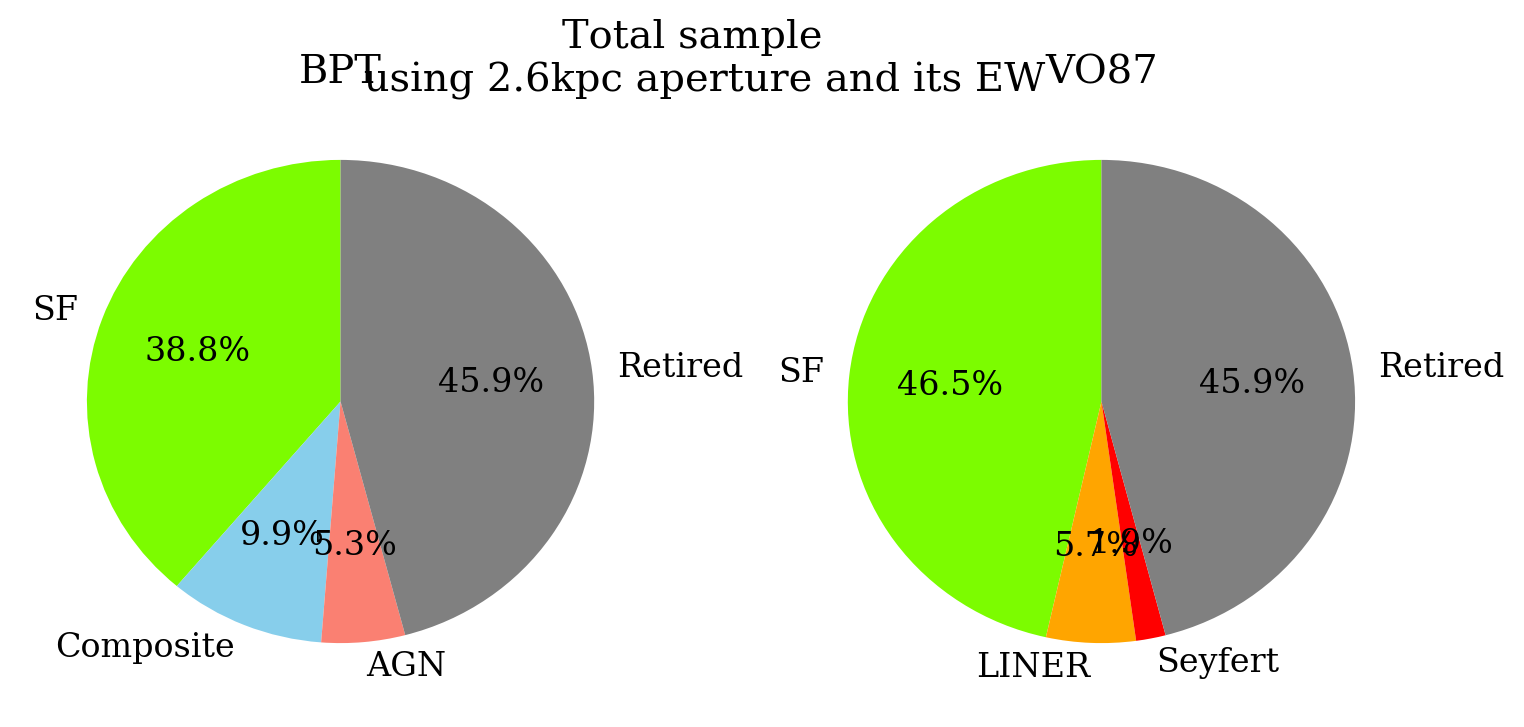

In [8]:
rAGN1, rSF1, rComposite, rSF2, rAGN2, rLINER, rRGmask, rnonRGmask = AGN_diagnosis(
    ring_fits, rew_ha, rOIII_Hb, rNII_Ha, rOIII_Hb, rSII_Ha,
    'Ha ring sample \n Using 2.6kpc aperture and its EW', [9, 4])
tAGN1, tSF1, tComposite, tSF2, tAGN2, tLINER, tRGmask, tnonRGmask = AGN_diagnosis(
    all_fits, tew_ha, tOIII_Hb, tNII_Ha, tOIII_Hb, tSII_Ha,
    'Total sample \n using 2.6kpc aperture and its EW', [9, 4])

### Ha ring sample的分布图

定义moving average函数，其中的变量有：line是mass bin的index；density是横坐标一个单位里取多少个点，可以选择10-50之间的一个数，最好不要让两个相邻的点一样高，否则有点over-sampling的嫌疑；number_limit是一个格子里最少的galaxy数目，一般设置为1-3之间；rxdata是2d histogram的x轴的名字；rydata同理；rmask是做分子的那些galaxy需要的mask；tmask是做分母的那些galaxy需要的mask。SSFR_bin是SSFR bin的宽度，一般是1或者0.5

In [9]:
def moving_average(line, SSFR_bin, density, step, number_limit, rxdata, rydata, txdata, tydata, rmask, tmask):
    xset = []
    np.array(xset)
    yset = []
    np.array(yset)
    errset = []
    np.array(errset)
    for j in range(0, density):
        forward = SSFR_bin / density * j
        #bins_for_SSFR = np.linspace(-13 + forward, -9 + forward, step)
        bins_for_SSFR = np.arange(-13 + forward, -9 + forward, SSFR_bin)
        bins_for_mass = np.linspace(8, 12, step)

        H_ring_bar_SSFR, bins_for_mass, bins_for_SSFR = np.histogram2d(
            rxdata[rmask], rydata[rmask], bins=(bins_for_mass, bins_for_SSFR))
        H_ring_bar_SSFR = H_ring_bar_SSFR.T

        H_base_SSFR, bins_for_mass, bins_for_SSFR = np.histogram2d(
            txdata[tmask],
            tydata[tmask],
            bins=(bins_for_mass, bins_for_SSFR))
        H_base_SSFR = H_base_SSFR.T

        H_base_SSFR[np.isnan(H_base_SSFR)] = 0

        H_bar_fraction = H_ring_bar_SSFR / H_base_SSFR
        H_bar_fraction[np.isnan(H_bar_fraction)] = 0

        SSFRshift = (bins_for_SSFR[1] - bins_for_SSFR[0]) / 2
        if sum(H_bar_fraction[:, line] != 0) == 0:
            continue

        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        x = bins_for_SSFR[:-1] + SSFRshift
        y = H_bar_fraction[:, line]
        num = H_base_SSFR[:, line]
        mask = (num >= number_limit)
        xset = np.append(xset, x[mask])
        yset = np.append(yset, y[mask])

        # Binomial Error #
        z = 0.842
        N = H_base_SSFR[:, line]
        err = z * np.sqrt(H_bar_fraction[:, line] *
                          (1 - H_bar_fraction[:, line]) / N)
        errset = np.append(errset, err[mask])

    return xset, yset, errset

In [10]:
def all_mass_moving_average(SSFR_bin, density, step, number_limit, rxdata, rydata, txdata, tydata, rmask,
                            tmask):
    xset = []
    np.array(xset)
    yset = []
    np.array(yset)
    errset = []
    np.array(errset)
    for j in range(0, density):
        forward = SSFR_bin / density * j
        #bins_for_SSFR = np.linspace(-13 + forward, -9 + forward, step)
        bins_for_SSFR = np.arange(-13 + forward, -9 + forward, SSFR_bin)
        bins_for_mass = np.linspace(8, 12, step)

        H_ring_bar_SSFR, bins_for_mass, bins_for_SSFR = np.histogram2d(
            rxdata[rmask], rydata[rmask], bins=(bins_for_mass, bins_for_SSFR))
        H_ring_bar_SSFR = H_ring_bar_SSFR.T

        H_base_SSFR, bins_for_mass, bins_for_SSFR = np.histogram2d(
            txdata[tmask],
            tydata[tmask],
            bins=(bins_for_mass, bins_for_SSFR))
        H_base_SSFR = H_base_SSFR.T

        H_base_SSFR[np.isnan(H_base_SSFR)] = 0

        SSFRshift = (bins_for_SSFR[1] - bins_for_SSFR[0]) / 2

        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        x = bins_for_SSFR[:-1] + SSFRshift
        y = H_ring_bar_SSFR.sum(axis=1) / H_base_SSFR.sum(axis=1)
        num = H_base_SSFR.sum(axis=1)
        mask = (num >= number_limit)
        xset = np.append(xset, x[mask])
        yset = np.append(yset, y[mask])
        
        # Binomial Error #
        z = 0.842
        N = H_base_SSFR.sum(axis=1)
        err = z * np.sqrt(y *(1 - y) / N)
        errset = np.append(errset, err[mask])

    return xset, yset, errset

In [11]:
def normalization(newx, newy):
    xvals = np.linspace(-12.5, -9.5, 10000)
    tck = itp.splrep(newx, newy)
    def f(x):
        return itp.splev(x, tck)
    integrate = sci.integrate.quad(f, -12, -9.5)[0]
    def g(x):
        return itp.splev(x, tck) / integrate
    y_bspline = itp.splev(xvals, tck) / integrate

    print(sci.integrate.quad(g, -12, -9.5)[0])
    return integrate, xvals, y_bspline

In [12]:
def total_sample_moving_average(SSFR_bin, density, step, number_limit, txdata, tydata, tmask):
    xset = []
    np.array(xset)
    yset = []
    np.array(yset)
    errset = []
    np.array(errset)
    for j in range(0, density):
        forward = SSFR_bin / density * j
        #bins_for_SSFR = np.linspace(-13 + forward, -9 + forward, step)
        bins_for_SSFR = np.arange(-13 + forward, -9 + forward, SSFR_bin)
        bins_for_mass = np.linspace(8, 12, step)

        H_base_SSFR, bins_for_mass, bins_for_SSFR = np.histogram2d(
            txdata[tmask],
            tydata[tmask],
            bins=(bins_for_mass, bins_for_SSFR))
        H_base_SSFR = H_base_SSFR.T

        H_base_SSFR[np.isnan(H_base_SSFR)] = 0

        SSFRshift = (bins_for_SSFR[1] - bins_for_SSFR[0]) / 2

        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        x = bins_for_SSFR[:-1] + SSFRshift
        y = H_base_SSFR.sum(axis=1)
        num = H_base_SSFR.sum(axis=1)
        mask = (num >= number_limit)
        xset = np.append(xset, x[mask])
        yset = np.append(yset, y[mask])
        
        # Binomial Error #
        z = 0.842
        N = H_base_SSFR.sum(axis=1)
        err = z * np.sqrt(y *(1 - y) / N)
        errset = np.append(errset, err[mask])

    return xset, yset, errset

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


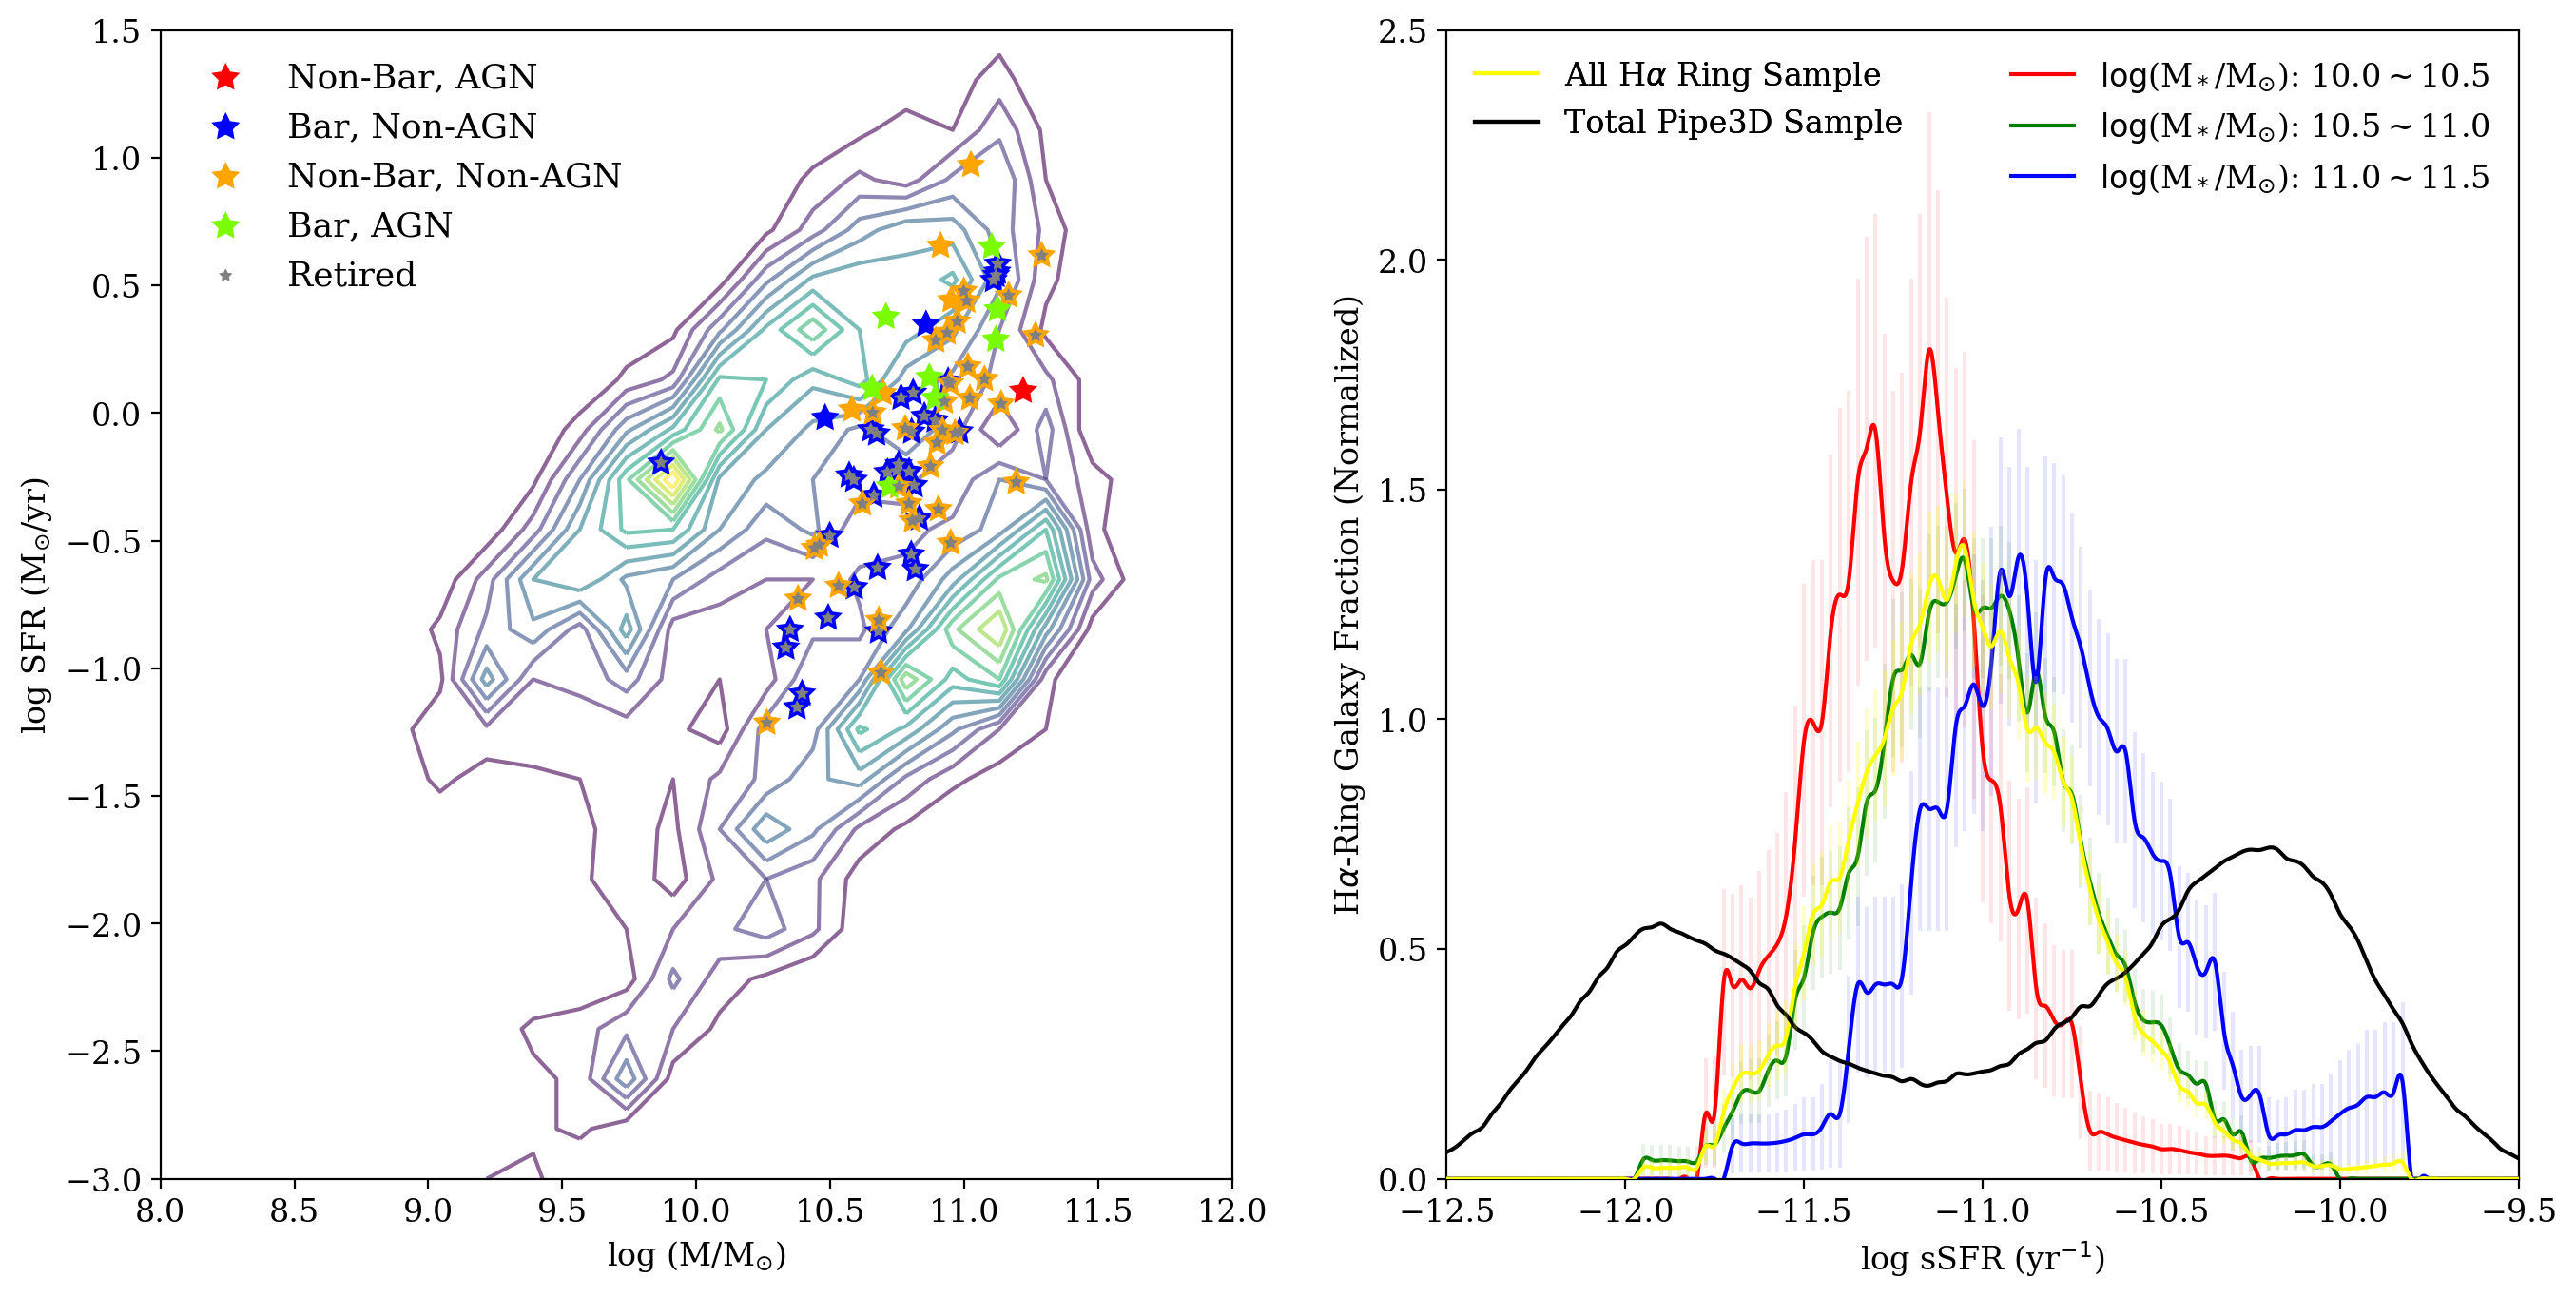

In [13]:
############ Ha ring sample的分布图 ##########
step = 25  # 是imshow每边的格子数
bins_for_SFR = np.linspace(-3, 1.5, step)
bins_for_SSFR = np.linspace(-13, -9, step)
bins_for_mass = np.linspace(8, 12, step)

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((1, 2), (0, 0))
#plt.style.use(astropy_mpl_style)

############## 为GZ1建立mask，同时给GZ1的星系建立各个类别比如spiral的mask。non_elli_mask意思是非椭圆星系 ##############

H_nelli_SFR, bins_for_mass, bins_for_SFR = np.histogram2d(
    tot_log_mass[tnelli_mask],
    tot_log_SFR[tnelli_mask],
    bins=(bins_for_mass, bins_for_SFR))
H_nelli_SFR = H_nelli_SFR.T
H_tot_SFR, bins_for_mass, bins_for_SFR = np.histogram2d(
    tot_log_mass, tot_log_SFR, bins=(bins_for_mass, bins_for_SFR))
H_tot_SFR = H_tot_SFR.T
H_ring_SFR, bins_for_mass, bins_for_SFR = np.histogram2d(
    ring_log_mass, ring_log_SFR, bins=(bins_for_mass, bins_for_SFR))
H_ring_SFR = H_ring_SFR.T

plt.contour(
    H_tot_SFR,
    15,
    cmap='viridis',
    alpha=0.6,
    extent=[
        bins_for_mass[0], bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]
    ],
    label='Total Pipe3D Sample',
    zorder=0)
plt.scatter(
    ring_log_mass[np.logical_and(~opBARmask, rAGN2 + rLINER)],
    ring_log_SFR[np.logical_and(~opBARmask, rAGN2 + rLINER)],
    label='Non-Bar, AGN',
    s=130,
    marker=(5, 1, 0),
    facecolors='red',
    edgecolors='none')
plt.scatter(
    ring_log_mass[np.logical_and(opBARmask, ~(rAGN2 + rLINER))],
    ring_log_SFR[np.logical_and(opBARmask, ~(rAGN2 + rLINER))],
    label='Bar, Non-AGN',
    s=130,
    marker=(5, 1, 0),
    facecolors='blue',
    edgecolors='none')
plt.scatter(
    ring_log_mass[np.logical_and(~opBARmask, ~(rAGN2 + rLINER))],
    ring_log_SFR[np.logical_and(~opBARmask, ~(rAGN2 + rLINER))],
    label='Non-Bar, Non-AGN',
    s=130,
    marker=(5, 1, 0),
    facecolors='orange',
    edgecolors='none')
plt.scatter(
    ring_log_mass[np.logical_and(opBARmask, rAGN2 + rLINER)],
    ring_log_SFR[np.logical_and(opBARmask, rAGN2 + rLINER)],
    label='Bar, AGN',
    s=130,
    marker=(5, 1, 0),
    facecolors='lawngreen',
    edgecolors='none')
plt.scatter(
    ring_log_mass[rRGmask],
    ring_log_SFR[rRGmask],
    label='Retired',
    s=30,
    marker=(5, 1, 0),
    facecolors='gray',
    edgecolors='none')
plt.xlabel('log (M/M$_{\odot}$)')
plt.ylabel('log SFR (M$_{\odot}$/yr)')
plt.legend(loc='upper left', fontsize=13, frameon=False)
plt.grid('off')


ax2 = plt.subplot2grid((1, 2), (0, 1))
step = 9  # 是imshow每边的格子数
bins_for_mass = np.linspace(8, 12, step)
colorset = [1, 1, 1, 1, 'r', 'g', 'b']

for i in range(4, 7):
    line = i
    xset, yset, errset = moving_average(line, 0.5, 20, 9, 3, ring_log_mass,
                                        ring_log_SSFR, tot_log_mass,
                                        tot_log_SSFR, rtot_mask, tnelli_mask)
    temp_array = []
    for k in range(0, len(xset)):
        temp_array.append([xset[k], yset[k]])
        newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
        newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]

    integrate, xvals, y_bspline = normalization(newx, newy)

    mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
        bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

    plt.plot(xvals, y_bspline, color=colorset[i], label=mass_bin_name)
    plt.errorbar(
        xset,
        yset / integrate,
        yerr=errset / integrate,
        fmt='none',
        alpha=0.1,
        color=colorset[i])

### 84 ring distribution
xset, yset, errset = all_mass_moving_average(
    0.5, 20, 9, 3, ring_log_mass, ring_log_SSFR, tot_log_mass, tot_log_SSFR,
    rtot_mask, tnelli_mask)

temp_array = []
for k in range(0, len(xset)):
    temp_array.append([xset[k], yset[k]])
    newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
    newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
integrate, xvals, y_bspline = normalization(newx, newy)

name = r'All H$\alpha$ Ring Sample'

plt.plot(xvals, y_bspline, color='yellow', label=name, zorder=9, alpha=1)
plt.errorbar(
    xset,
    yset / integrate,
    yerr=errset / integrate,
    fmt='none',
    alpha=0.2,
    c='yellow',
    zorder=10)

### 2704 total distribution
xset, yset, errset = total_sample_moving_average(
    0.5, 20, 9, 3, tot_log_mass, tot_log_SSFR, ttot_mask)

temp_array = []
for k in range(0, len(xset)):
    temp_array.append([xset[k], yset[k]])
    newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
    newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
integrate, xvals, y_bspline = normalization(newx, newy)

name = r'Total Pipe3D Sample'

plt.plot(xvals, y_bspline, color='k', label=name, zorder=9, alpha=1)
plt.errorbar(
    xset,
    yset / integrate,
    yerr=errset / integrate,
    fmt='none',
    alpha=0.1,
    c='k',
    zorder=1)

lines = ax2.get_lines()
nameset = [
    '$\log$(M$_*$/M$_{\odot}$): ' + str(bins_for_mass[line]) + '$\sim$' + str(
        bins_for_mass[line + 1]) for line in range(4, 7)
]
legend1 = plt.legend(
    [lines[i] for i in [0, 1, 2]], nameset, loc='upper right', frameon=False)
legend2 = plt.legend(
    [lines[i] for i in [3, 4]],
    [r'All H$\alpha$ Ring Sample', 'Total Pipe3D Sample'],
    loc='upper left',
    frameon=False)
ax2.add_artist(legend1)
ax2.add_artist(legend2)

plt.ylim(0, 2.5)
plt.xlim(-12.5, -9.5)
plt.xlabel('log sSFR (yr$^{-1}$)')
plt.ylabel(r'H$\alpha$-Ring Galaxy Fraction (Normalized)')
plt.grid('off')
#plt.legend(loc='upper right',frameon=False)
#plt.title('Ring Galaxy Fraction-sSFR Line Chart (Normalized)')
plt.subplots_adjust(hspace=0.2)
plt.savefig('fig2.pdf',dpi=400, bbox_inches='tight')
plt.show()

In [14]:
print(sum(opBARmask))

44


In [15]:
print(ring_log_mass[np.logical_and(~opBARmask, rAGN2 + rLINER)])

[ 11.2192812]


### 绘制ring sample和total sample的BPT diagram，用于paper
需要输入的参数有：ring的EW[Ha]数组，ring的NII/Ha，ring的OIII/Hb，ring的SII/Ha，ring的OIII/Hb，total的EW[Ha]数组，total的NII/Ha，OIII/Hb，SII/Ha，OIII/Hb，以及是否需要保存图片。如果写`'yes'`，则会保存为`'paper_BPT.png'`，如果写别的，则不会保存。

In [16]:
def paper_BPT_and_RG(rthis_ew, rthis_x, rthis_y, rthis_x2, rthis_y2, tthis_ew,
                     tthis_x, tthis_y, tthis_x2, tthis_y2, savefile):
    fig = plt.figure(figsize=(24, 6))
    ax1 = plt.subplot2grid((1, 4), (0, 0))
    rRGmask = (rthis_ew <= 3)
    rnonRGmask = (rthis_ew > 3)
    plt.scatter(
        rthis_x[rRGmask],
        rthis_y[rRGmask],
        c='gray',
        s=5,
        marker='o',
        label='RG',
        alpha=0.5)
    plt.scatter(
        rthis_x[np.logical_and(rnonRGmask, rAGN2)],
        rthis_y[np.logical_and(rnonRGmask, rAGN2)],
        c='red',
        s=15,
        marker='o',
        label='Seyfert',
        alpha=0.5)
    plt.scatter(
        rthis_x[np.logical_and(rnonRGmask, rLINER)],
        rthis_y[np.logical_and(rnonRGmask, rLINER)],
        c='orange',
        s=15,
        marker='o',
        label='LINER',
        alpha=0.5)
    plt.scatter(
        rthis_x[np.logical_and(rnonRGmask, rComposite)],
        rthis_y[np.logical_and(rnonRGmask, rComposite)],
        c='blue',
        s=15,
        marker='o',
        label='Composite',
        alpha=0.5)
    plt.scatter(
        rthis_x[np.logical_and(rnonRGmask, rSF1)],
        rthis_y[np.logical_and(rnonRGmask, rSF1)],
        c='green',
        s=15,
        marker='o',
        label='SF',
        alpha=0.5)
    x = np.linspace(-1.28, 0.04, 100)
    y1 = 0.61 / (x - 0.05) + 1.30
    plt.plot(x, y1, 'r--', alpha=0.5)
    x = np.linspace(-2.5, 0.3, 100)
    y2 = 0.61 / (x - 0.47) + 1.19
    plt.plot(x, y2, 'b--', alpha=0.5)
    x = np.linspace(-0.18, 0.9, 100)
    #y3 = 1.05*x + 0.45
    #plt.plot(x,y3,'g--',alpha=0.5)
    plt.text(-0.8, -0.1, 'SF')
    plt.text(0.2, 0.9, 'AGN')
    plt.text(-0.22, -0.85, 'Composite')
    plt.xlim(-1.3, 0.6)
    plt.ylim(-1.2, 1.3)
    xmin, xmax = ax1.get_xlim()
    ymin, ymax = ax1.get_ylim()
    plt.text(
        0.05 * (xmax - xmin) + xmin,
        ymin + (ymax - ymin) * 0.90,
        '(a)',
        fontsize=16)
    plt.ylabel(r'$\log$([O III]/H$\beta$)')
    plt.xlabel(r'$\log$([N II]/H$\alpha$)')
    ax1.yaxis.set_ticks_position('both')
    ax1.tick_params(direction='in')
    #plt.title('RG='+ str(sum(RGmask))+' and Non-RG='+str(sum(nonRGmask)))
    plt.legend(fontsize=12, framealpha=0.5, edgecolor='k')
    plt.grid('off')
    plt.xticks([-1,-0.5,0,0.5])

    ax2 = plt.subplot2grid((1, 4), (0, 1))
    RGmask = (rthis_ew <= 3)
    nonRGmask = (rthis_ew > 3)
    plt.scatter(
        rthis_x2[np.logical_and(rnonRGmask, rAGN2)],
        rthis_y2[np.logical_and(rnonRGmask, rAGN2)],
        c='red',
        s=15,
        marker='o',
        label='Seyfert',
        alpha=0.5)
    plt.scatter(
        rthis_x2[np.logical_and(rnonRGmask, rLINER)],
        rthis_y2[np.logical_and(rnonRGmask, rLINER)],
        c='orange',
        s=15,
        marker='o',
        label='LINER',
        alpha=0.5)
    plt.scatter(
        rthis_x2[np.logical_and(rnonRGmask, rComposite)],
        rthis_y2[np.logical_and(rnonRGmask, rComposite)],
        c='blue',
        s=15,
        marker='o',
        label='Composite',
        alpha=0.5)
    plt.scatter(
        rthis_x2[np.logical_and(rnonRGmask, rSF1)],
        rthis_y2[np.logical_and(rnonRGmask, rSF1)],
        c='green',
        s=15,
        marker='o',
        label='SF',
        alpha=0.5)
    plt.scatter(
        rthis_x2[rRGmask],
        rthis_y2[rRGmask],
        c='gray',
        s=5,
        marker='o',
        label='RG',
        alpha=0.3)
    
    x = np.linspace(-0.3, 0.5, 100)
    y1 = 1.89 * x + 0.76
    plt.plot(x, y1, 'g--', alpha=0.5)
    x = np.linspace(-2.5, 0.1, 100)
    y2 = 0.72 / (x - 0.32) + 1.30
    y3 = 0.48 / (x - 0.10) + 1.30
    plt.plot(x, y2, 'b--', alpha=0.5)
    #plt.plot(x,y3,'r--',alpha=0.5)
    
    plt.text(-1, -0.8, 'SF & Composite')
    plt.text(-0.8, 1, 'Seyfert')
    plt.text(0.2, 0.7, 'LINER')
    plt.xlim(-1.2, 0.6)
    plt.ylim(-1.2, 1.3)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    plt.text(
        0.05 * (xmax - xmin) + xmin,
        ymin + (ymax - ymin) * 0.90,
        '(b)',
        fontsize=16)
    #plt.ylabel(r'$\log$ OIII/H$\beta$')
    plt.xlabel(r'$\log$([S II]/H$\alpha$)')
    ax2.yaxis.set_ticks_position('both')
    ax2.tick_params(direction='in')
    #plt.title('RG='+ str(sum(RGmask))+' and Non-RG='+str(sum(nonRGmask)))
    #plt.legend(frameon=False, fontsize=12)
    plt.grid('off')
    plt.xticks([-1,-0.5,0,0.5])

    ax3 = plt.subplot2grid((1, 4), (0, 2))
    tRGmask = (tthis_ew <= 3)
    tnonRGmask = (tthis_ew > 3)
    plt.scatter(
        tthis_x[tRGmask],
        tthis_y[tRGmask],
        c='gray',
        s=5,
        marker='o',
        label='RG',
        alpha=0.3)
    plt.scatter(
        tthis_x[np.logical_and(tnonRGmask, tLINER)],
        tthis_y[np.logical_and(tnonRGmask, tLINER)],
        c='orange',
        s=15,
        marker='o',
        label='LINER',
        alpha=0.5)
    plt.scatter(
        tthis_x[np.logical_and(tnonRGmask, tAGN2)],
        tthis_y[np.logical_and(tnonRGmask, tAGN2)],
        c='red',
        s=15,
        marker='o',
        label='Seyfert',
        alpha=0.5)
    plt.scatter(
        tthis_x[np.logical_and(tnonRGmask, tComposite)],
        tthis_y[np.logical_and(tnonRGmask, tComposite)],
        c='blue',
        s=15,
        marker='o',
        label='Composite',
        alpha=0.5)
    plt.scatter(
        tthis_x[np.logical_and(tnonRGmask, tSF1)],
        tthis_y[np.logical_and(tnonRGmask, tSF1)],
        c='green',
        s=15,
        marker='o',
        label='SF',
        alpha=0.5)

    x = np.linspace(-1.28, 0.04, 100)
    y1 = 0.61 / (x - 0.05) + 1.30
    plt.plot(x, y1, 'r--', alpha=0.5)
    x = np.linspace(-2.5, 0.3, 100)
    y2 = 0.61 / (x - 0.47) + 1.19
    plt.plot(x, y2, 'b--', alpha=0.5)
    x = np.linspace(-0.18, 0.9, 100)
    #y3 = 1.05*x + 0.45
    #plt.plot(x,y3,'g--',alpha=0.5)
    plt.text(-0.95, -0.65, 'SF')
    plt.text(0.2, 0.9, 'AGN')
    plt.text(-0.22, -0.85, 'Composite')
    plt.xlim(-1.3, 0.6)
    plt.ylim(-1.2, 1.3)
    xmin, xmax = ax3.get_xlim()
    ymin, ymax = ax3.get_ylim()
    plt.text(
        0.05 * (xmax - xmin) + xmin,
        ymin + (ymax - ymin) * 0.90,
        '(c)',
        fontsize=16)
    plt.xlabel(r'$\log$([N II]/H$\alpha$)')
    ax3.yaxis.set_ticks_position('both')
    ax3.tick_params(direction='in')
    #plt.title('RG='+ str(sum(tRGmask))+' and Non-RG='+str(sum(tnonRGmask)))
    #plt.legend(frameon=False, fontsize=12)
    plt.grid('off')
    plt.xticks([-1,-0.5,0,0.5])

    ax4 = plt.subplot2grid((1, 4), (0, 3))
    tRGmask = (tthis_ew <= 3)
    tnonRGmask = (tthis_ew > 3)
    plt.scatter(
        tthis_x2[tRGmask],
        tthis_y2[tRGmask],
        c='gray',
        s=5,
        marker='o',
        label='RG',
        alpha=0.3)
    plt.scatter(
        tthis_x2[np.logical_and(tnonRGmask, tAGN2)],
        tthis_y2[np.logical_and(tnonRGmask, tAGN2)],
        c='red',
        s=15,
        marker='o',
        label='Seyfert',
        alpha=0.5)

    plt.scatter(
        tthis_x2[np.logical_and(tnonRGmask, tSF1)],
        tthis_y2[np.logical_and(tnonRGmask, tSF1)],
        c='green',
        s=15,
        marker='o',
        label='SF',
        alpha=0.5)
    plt.scatter(
        tthis_x2[np.logical_and(tnonRGmask, tComposite)],
        tthis_y2[np.logical_and(tnonRGmask, tComposite)],
        c='blue',
        s=15,
        marker='o',
        label='Composite',
        alpha=0.5)
    plt.scatter(
        tthis_x2[np.logical_and(tnonRGmask, tLINER)],
        tthis_y2[np.logical_and(tnonRGmask, tLINER)],
        c='orange',
        s=15,
        marker='o',
        label='LINER',
        alpha=0.5)
    x = np.linspace(-0.3, 0.5, 100)
    y1 = 1.89 * x + 0.76
    plt.plot(x, y1, 'g--', alpha=0.5)
    x = np.linspace(-2.5, 0.1, 100)
    #y2=0.72/(x-0.32)+1.30
    y3 = 0.48 / (x - 0.10) + 1.30
    plt.plot(x, y2, 'b--', alpha=0.5)
    #plt.plot(x,y3,'r--',alpha=0.5)
    plt.text(-1, -1.05, 'SF & Composite')
    plt.text(-0.8, 1, 'Seyfert')
    plt.text(0.2, 0.7, 'LINER')
    plt.xlim(-1.2, 0.6)
    plt.ylim(-1.2, 1.3)
    xmin, xmax = ax4.get_xlim()
    ymin, ymax = ax4.get_ylim()
    plt.text(
        0.05 * (xmax - xmin) + xmin,
        ymin + (ymax - ymin) * 0.90,
        '(d)',
        fontsize=16)
    plt.xlabel(r'$\log$([S II]/H$\alpha$)')
    ax4.yaxis.set_ticks_position('both')
    ax4.tick_params(direction='in')
    #ax4.yaxis.set_label_position("right")
    #plt.title('RG='+ str(sum(tRGmask))+' and Non-RG='+str(sum(tnonRGmask)))
    #plt.legend(fontsize=12,framealpha=0.5, edgecolor='k')
    plt.grid('off')
    plt.xticks([-1,-0.5,0,0.5])
    
    ax2.get_shared_y_axes().join(ax1, ax2)
    ax2.set_yticklabels([])
    ax3.get_shared_y_axes().join(ax2, ax3)
    ax3.set_yticklabels([])
    ax4.get_shared_y_axes().join(ax3, ax4)
    ax4.set_yticklabels([])
    plt.subplots_adjust(wspace=0)
    if savefile=='yes':
        plt.savefig('paper_BPT.pdf', dpi=400, bbox_inches='tight')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: divide by zero encountered in true_divide


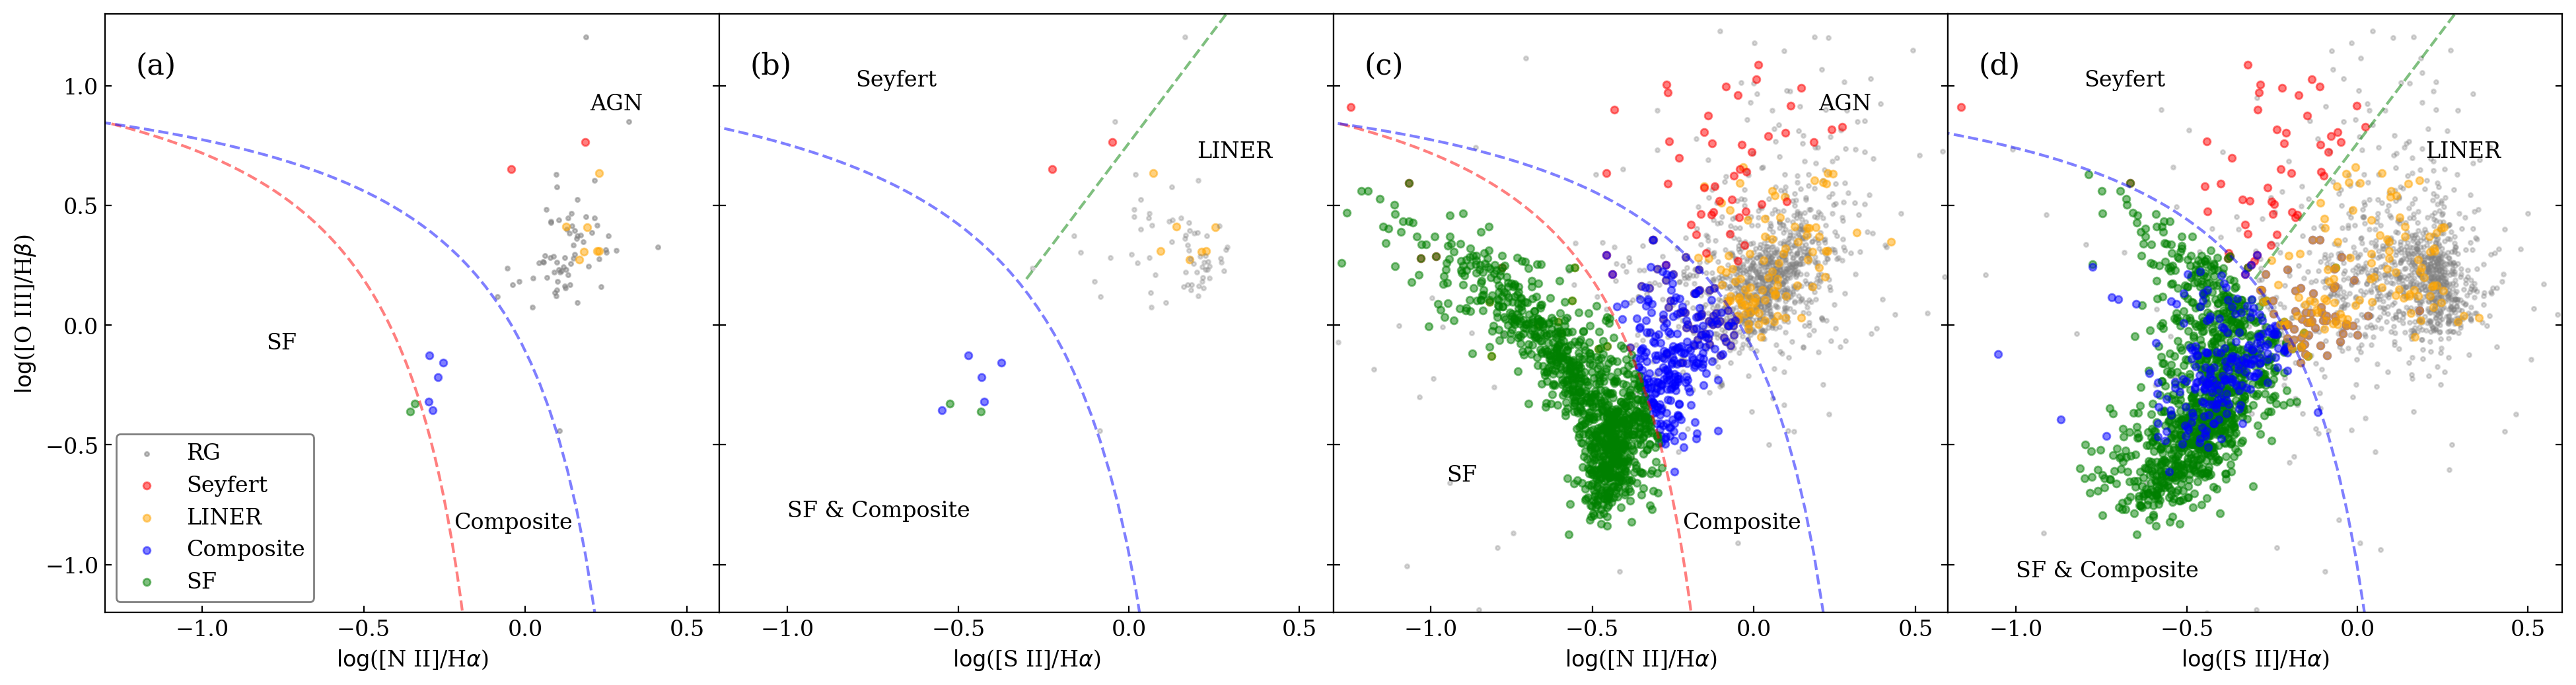

In [17]:
paper_BPT_and_RG(rew_ha, rNII_Ha, rOIII_Hb, rSII_Ha, rOIII_Hb, tew_ha, tNII_Ha, tOIII_Hb, tSII_Ha, tOIII_Hb, 'yes')

### 定义ring sample和total sample的BARmask.
BARmask是根据GZ1定义的，条件见下面4个step。BARLENmask是既有bar又有GZ2的barlength的。仍然，分为rBARmask和tBARmask.

In [18]:
############## 为ring galaxy 建立BARmask和BARLENmask ################
bar_threshold = 0.4
step1 = np.logical_and(
    ring_fits[1].data['t01_smooth_or_features_a02_features_or_disk_debiased']>= 0.430, 
    ring_fits[1].data['t02_edgeon_a05_no_debiased'] >= 0.715)
step2 = ring_fits[1].data['t02_edgeon_a05_no_count'] >= 10
step3 = np.logical_and(step1, step2)
step4 = np.logical_and(
    step3, ring_fits[1].data['t03_bar_a06_bar_debiased'] >= bar_threshold)
rBARmask = step4

print("Bar Galaxy number in ring sample is %d" % sum(rBARmask))
print("GZ Galaxy number in ring sample is %d" % sum(rGZ1mask))
rBARLENmask = np.logical_and(rBARmask,
                            ~np.isnan(ring_fits[1].data['length_avg']))
bar_length_scaled = ring_fits[1].data['length_scaled']

#### 为ring galaxy 建立BARmask和BARLENmask ####
bar_threshold = 0.4
step1 = np.logical_and(
        all_fits[1].data['t01_smooth_or_features_a02_features_or_disk_debiased'] >=0.430, 
        all_fits[1].data['t02_edgeon_a05_no_debiased'] >= 0.715)
step2 = all_fits[1].data['t02_edgeon_a05_no_count'] >= 10
step3 = np.logical_and(step1, step2)
step4 = np.logical_and(
    step3, all_fits[1].data['t03_bar_a06_bar_debiased'] >= bar_threshold)
tBARmask = step4

print("Bar Galaxy number in total sample is %d" % sum(tBARmask))

Bar Galaxy number in ring sample is 31
GZ Galaxy number in ring sample is 70
Bar Galaxy number in total sample is 259


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


### Total sample中的BAR fraction的分布情况
BAR_fraction_line_chart的参数分别是morphology_mask，如果要看disk的则写disk_mask，要看总共的就写GZ1mask。注意，原来ring_fits中的'optical_bar'是我人眼识别出来的。这里应该用rBARmask，是GZ1的结果。

定义paper_bar_fraction_line_chart函数，其中的变量有：rBARMASK是ring sample里barred-galaxies的mask；tBARMASK是total sample里的barred-galaxies的mask；r_morphology_mask和t_morphology_mask是对morphology进行控制，比如disk之类的.

In [19]:
def paper_bar_fraction_line_chart(SSFR_bin, density, rBARMASK, tBARMASK, r_morphology_mask, t_morphology_mask, number_limit, notes, savefile):
    ################ bar RATIO #################
    ################ 此处的AGN指的是VO87中的AGN(Seyfert)+LINER #################
    fig = plt.figure(figsize=(20, 8))
    step = 9  # 是imshow每边的格子数
    colorset = [1, 1, 1, 1, 'r', 'g', 'b']

    ax1 = plt.subplot2grid((1, 2), (0, 0))
    for i in range(4, 7):
        line = i
        xset, yset, errset = moving_average(
            line, SSFR_bin, density, 9, 3, ring_log_mass, ring_log_SSFR, ring_log_mass, ring_log_SSFR,
            np.logical_and(rBARMASK, r_morphology_mask), r_morphology_mask)
        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        plt.errorbar(
            xset,
            yset,
            yerr=errset,
            fmt='none',
            alpha=0.3,
            color=colorset[i],
            capsize=4)
        #plt.plot(xset, yset, 'o', color=colorset[i])

        # 把这些数据点按照x大小排序，好用plot画图

        # 对x从小到大进行排序，从而方便用plt.plot画图
        temp_array = []
        for k in range(0, len(xset)):
            temp_array.append([xset[k], yset[k]])
            newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
            newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
        plt.plot(newx, newy, label=mass_bin_name, color=colorset[i])
        
    plt.text(-12.4, 1.03, r'(a): H$\alpha$ ring sample', fontsize=18)
    plt.ylim(0, 1.1)
    plt.xlim(-12.5, -9.5)
    plt.xlabel('log sSFR (yr$^{-1}$)')
    plt.ylabel('Bar Fraction')
    plt.legend(loc='upper right', frameon=False)
    plt.grid('off')
    #plt.title('Bar Fraction Line Chart \n Fraction-sSFR (bin=1)\n'+ notes)

    ax2 = plt.subplot2grid((1, 2), (0, 1))
    for i in range(4, 7):
        line = i
        xset, yset, errset = moving_average(
            line, SSFR_bin, density, 9, 3, tot_log_mass, tot_log_SSFR, tot_log_mass, tot_log_SSFR,
            np.logical_and(tBARMASK, t_morphology_mask), t_morphology_mask)
        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        plt.errorbar(
            xset,
            yset,
            yerr=errset,
            fmt='none',
            alpha=0.3,
            color=colorset[i],
            capsize=4)
        #plt.plot(xset, yset, 'o', color=colorset[i], markersize=2)

        # 把这些数据点按照x大小排序，好用plot画图

        # 对x从小到大进行排序，从而方便用plt.plot画图
        temp_array = []
        for k in range(0, len(xset)):
            temp_array.append([xset[k], yset[k]])
            newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
            newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
        plt.plot(newx, newy, label=mass_bin_name, color=colorset[i])

    plt.text(-12.4, 1.03, '(b): Pipe3D total sample', fontsize=18)
    plt.ylim(0, 1.1)
    plt.xlim(-12.5, -9.5)
    plt.xlabel('log sSFR (yr$^{-1}$)')
    plt.ylabel('Bar Fraction')
    plt.legend(loc='upper right', frameon=False)
    plt.grid('off')
    ax1.tick_params(direction='in')
    ax2.tick_params(direction='in')
    
    print(notes)
    if savefile=='yes':
        plt.savefig('fig5-1.pdf', dpi=400, bbox_inches='tight')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


bar Ha ring/disk Ha ring


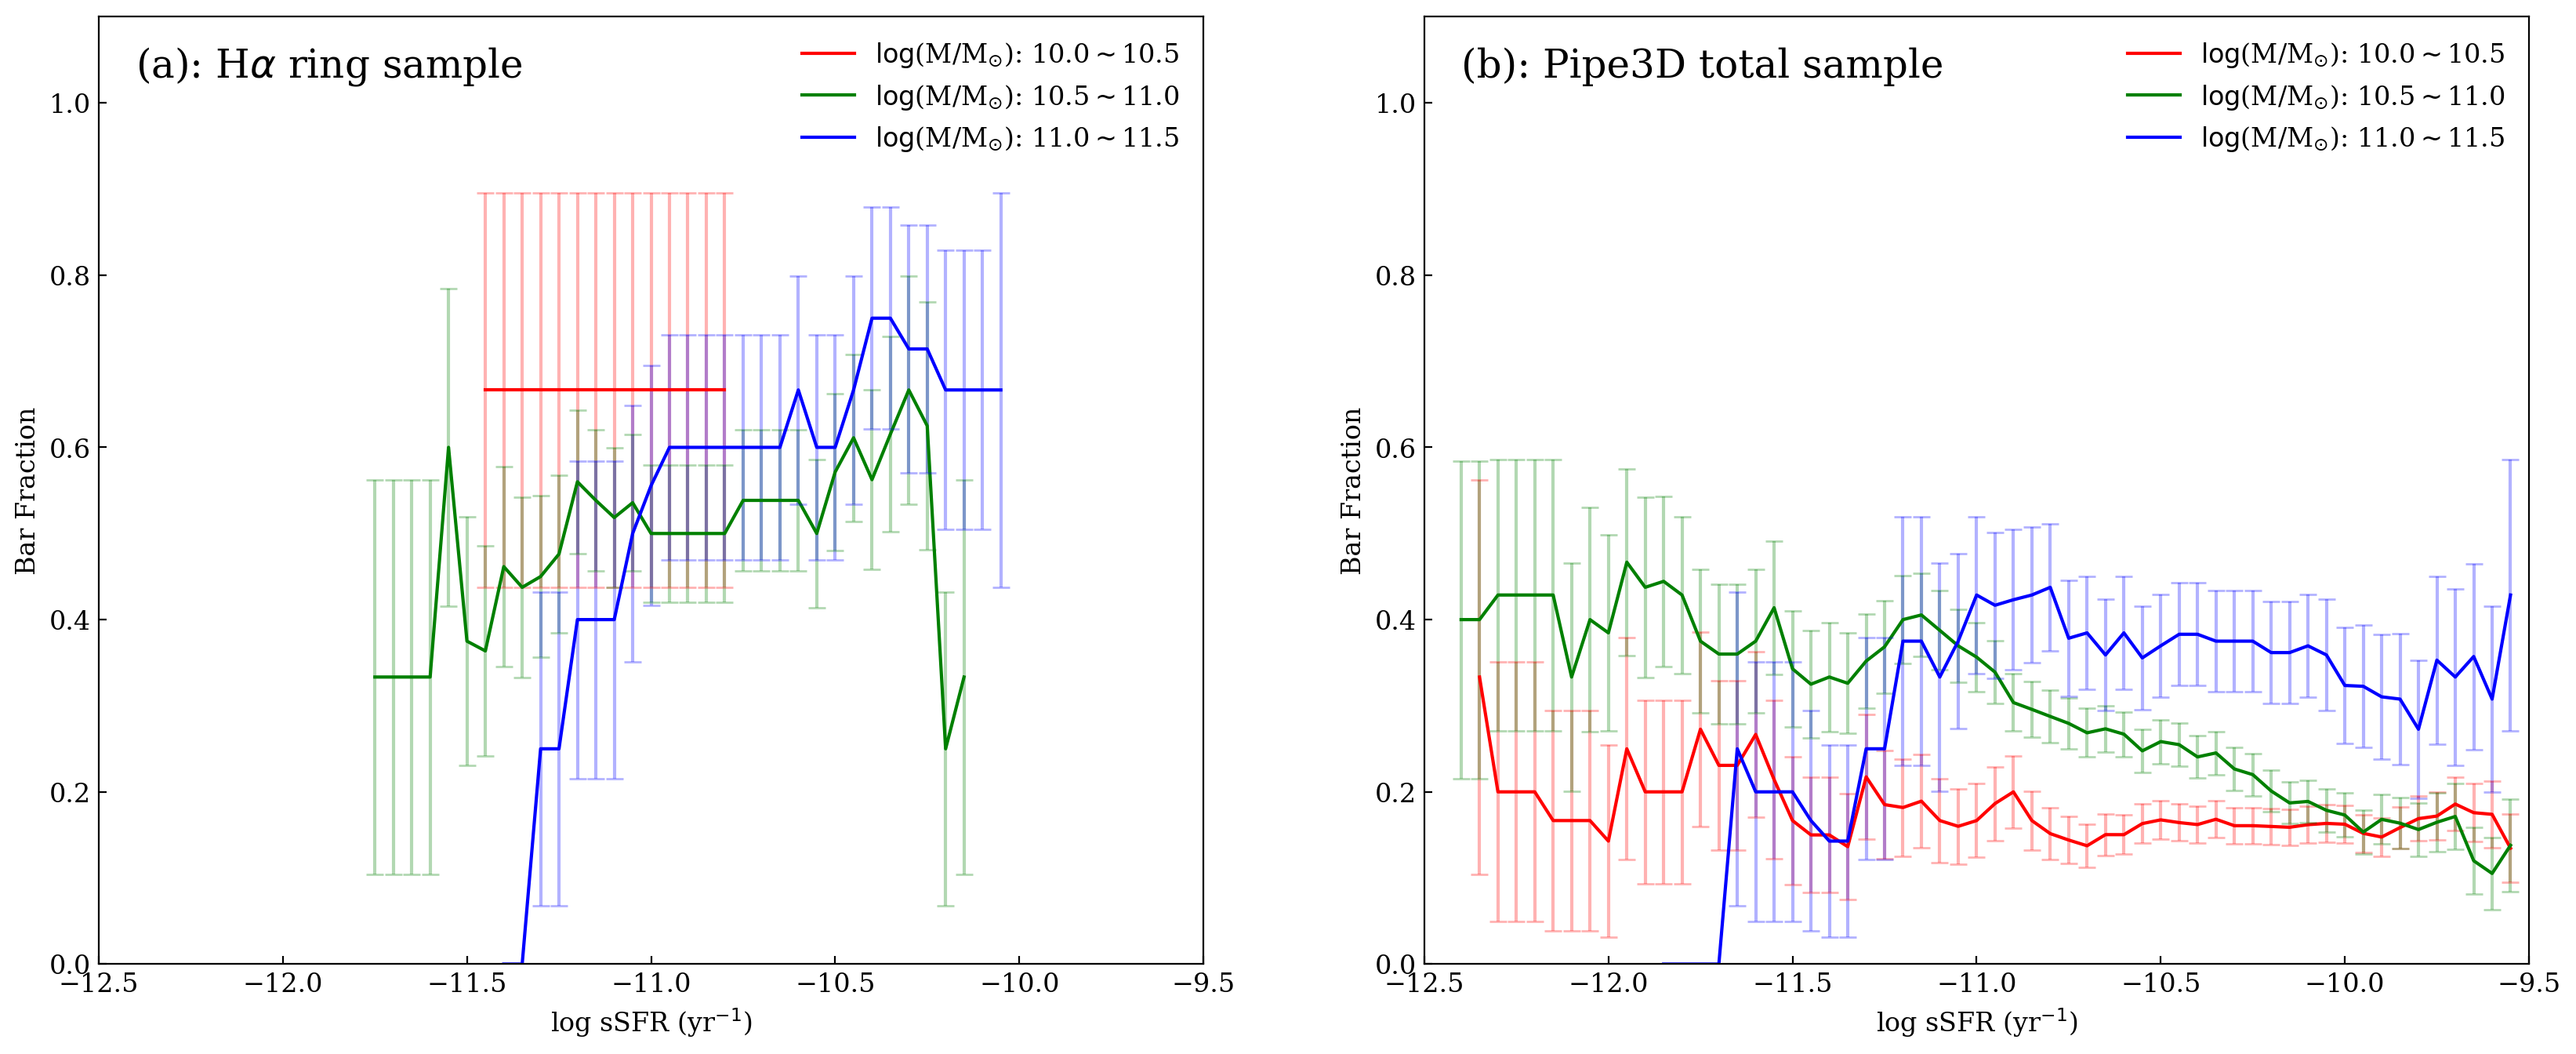

In [20]:
paper_bar_fraction_line_chart(1, 20, rBARmask, tBARmask, rdisk_mask, tdisk_mask, 2, 'bar Ha ring/disk Ha ring', 'yes')

接下来是AGN。

In [21]:
def paper_AGN_fraction_line_chart(SSFR_bin, density, r_morphology_mask,
                                  rAGN_type, t_morphology_mask, tAGN_type,
                                  rRGmask, tRGmask, number_limit, notes, savefile):
    ################ AGN RATIO #################
    ################ 此处的AGN指的是VO87中的AGN+LINER #################
    fig = plt.figure(figsize=(20, 8))
    # plt.style.use(astropy_mpl_style)
    step = 9  # 是imshow每边的格子数
    colorset = [1, 1, 1, 1, 'r', 'g', 'b']
    ax1 = plt.subplot2grid((1, 2), (0, 0))
    ############ 不同mass bin的AGN fraction #################
    for i in range(5, 7):
        line = i
        xset, yset, errset = moving_average(
            line, SSFR_bin, density, 9, 3, ring_log_mass, ring_log_SSFR,
            ring_log_mass, ring_log_SSFR,
            np.logical_and(rAGN_type, r_morphology_mask), r_morphology_mask)
        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        plt.errorbar(
            xset,
            yset,
            yerr=errset,
            fmt='none',
            alpha=0.4,
            color=colorset[i],
            capsize=4)

        temp_array = []
        for k in range(0, len(xset)):
            temp_array.append([xset[k], yset[k]])
            newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
            newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
        plt.plot(newx, newy, label=mass_bin_name, color=colorset[i])

    ############ 所有mass bin的RG的分布图 #################
    xset, yset, errset = all_mass_moving_average(
        SSFR_bin, density, 9, 2, ring_log_mass,
        ring_log_SSFR, ring_log_mass, ring_log_SSFR,
        np.logical_and(rRGmask, r_morphology_mask), r_morphology_mask)
    plt.errorbar(
        xset,
        yset,
        yerr=errset,
        fmt='none',
        alpha=0.3,
        color='gray',
        capsize=4)
    temp_array = []
    for k in range(0, len(xset)):
        temp_array.append([xset[k], yset[k]])
        newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
        newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
    plt.plot(newx, newy, label='RG fraction', color='gray')

    plt.ylim(0, 1.1)
    plt.xlim(-12.5, -9.5)
    plt.text(-12.4, 0.93 + 0.1, r'(a): H$\alpha$ ring sample', fontsize=18)
    plt.xlabel('log sSFR (yr$^{-1}$)')
    plt.ylabel('AGN Fraction')
    plt.legend(loc='upper right', frameon=False)
    ax1.tick_params(direction='in')
    #plt.title('AGN Fraction Line Chart \n Fraction-sSFR (bin=1)\n'+ notes)
    plt.grid('off')

    ax2 = plt.subplot2grid((1, 2), (0, 1))
    ############ 不同mass bin的AGN fraction #################
    for i in range(4, 7):
        line = i
        xset, yset, errset = moving_average(
            line, SSFR_bin, density, 9, 3, tot_log_mass, tot_log_SSFR,
            tot_log_mass, tot_log_SSFR,
            np.logical_and(tAGN_type, t_morphology_mask), t_morphology_mask)
        mass_bin_name = '$\log$(M/M$_{\odot}$): ' + str(
            bins_for_mass[line]) + '$\sim$' + str(bins_for_mass[line + 1])

        plt.errorbar(
            xset,
            yset,
            yerr=errset,
            fmt='none',
            alpha=0.3,
            color=colorset[i],
            capsize=4)

        temp_array = []
        for k in range(0, len(xset)):
            temp_array.append([xset[k], yset[k]])
            newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
            newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
        plt.plot(newx, newy, label=mass_bin_name, color=colorset[i])

    ############ 所有mass bin的RG的分布图
    #################
    xset, yset, errset = all_mass_moving_average(
        SSFR_bin, density, 9, 2, tot_log_mass,
        tot_log_SSFR, tot_log_mass, tot_log_SSFR,
        np.logical_and(tRGmask, t_morphology_mask), t_morphology_mask)
    plt.errorbar(
        xset,
        yset,
        yerr=errset,
        fmt='none',
        alpha=0.4,
        color='gray',
        capsize=4)
    temp_array = []
    for k in range(0, len(xset)):
        temp_array.append([xset[k], yset[k]])
        newx = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[0]
        newy = np.array(list(sorted(temp_array, key=lambda x: x[0]))).T[1]
    plt.plot(newx, newy, label='RG fraction', color='gray')

    plt.ylim(0, 1.1)
    plt.xlim(-12.5, -9.5)
    plt.text(-12.4, 0.93 + 0.1, '(b): Pipe3D total sample', fontsize=18)
    plt.xlabel('log sSFR (yr$^{-1}$)')
    plt.ylabel('AGN Fraction')
    plt.legend(loc='upper right', frameon=False)
    ax1.tick_params(direction='in')
    #plt.title('AGN Fraction Line Chart \n Fraction-sSFR (bin=1)\n'+ notes)
    plt.grid('off')
    if savefile=='yes':
        plt.savefig('fig7-1.pdf', dpi=400, bbox_inches='tight')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


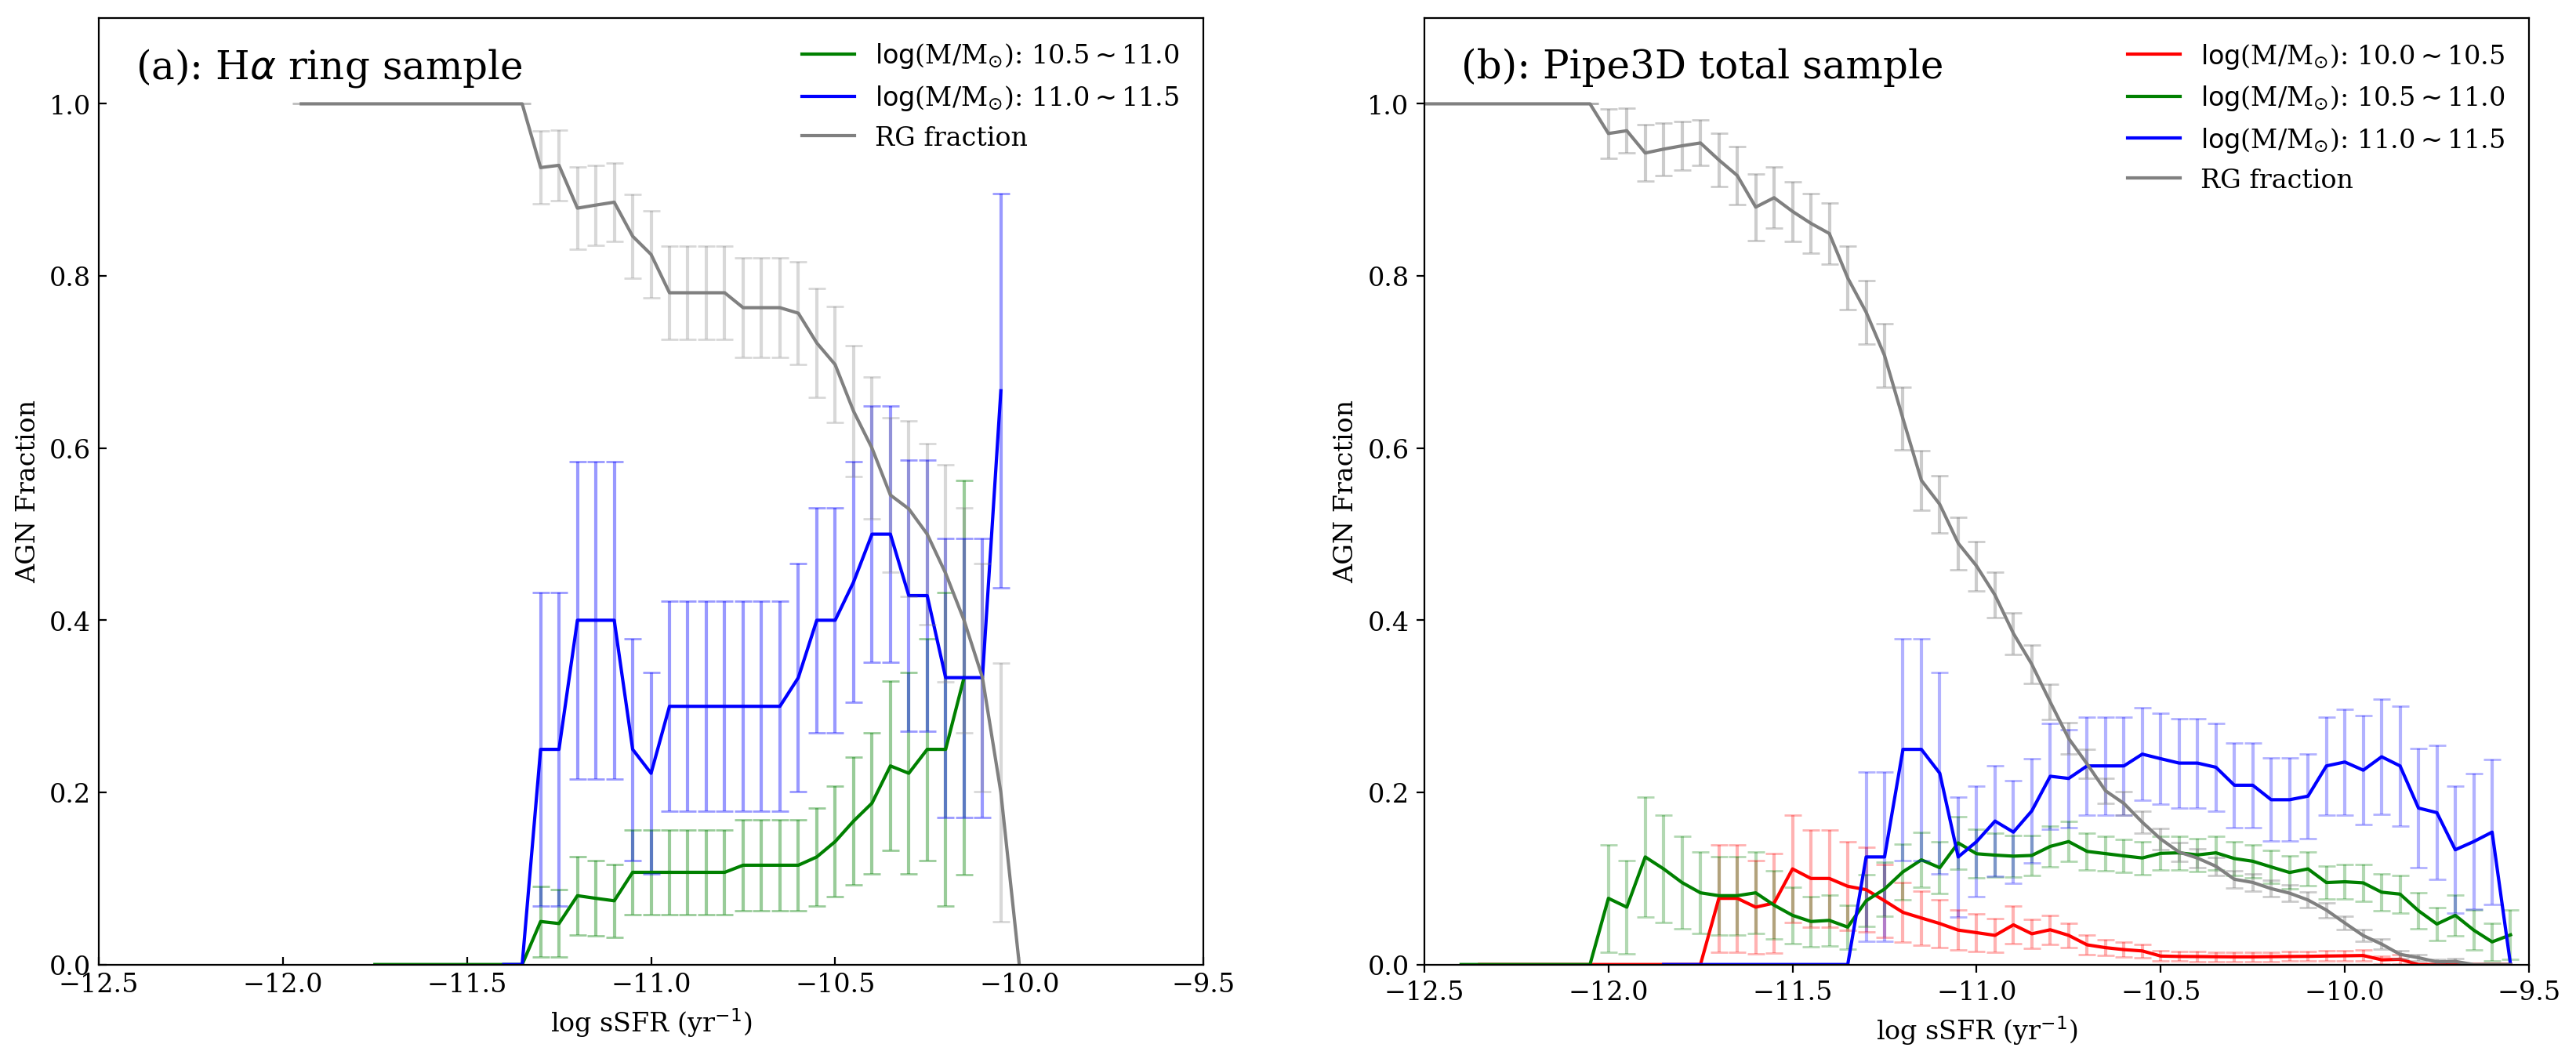

In [22]:
paper_AGN_fraction_line_chart(1, 20, rdisk_mask, rAGN1, tdisk_mask, tAGN1, rRGmask, tRGmask, 2,'disk+AGN1', 'yes')

### Bulge to Total ratio

In [23]:
#bulge mask 只选 mass 大于10小于11.5的
bulge_mass_mask=np.logical_and(tot_log_mass>=10, tot_log_mass<=11.5)

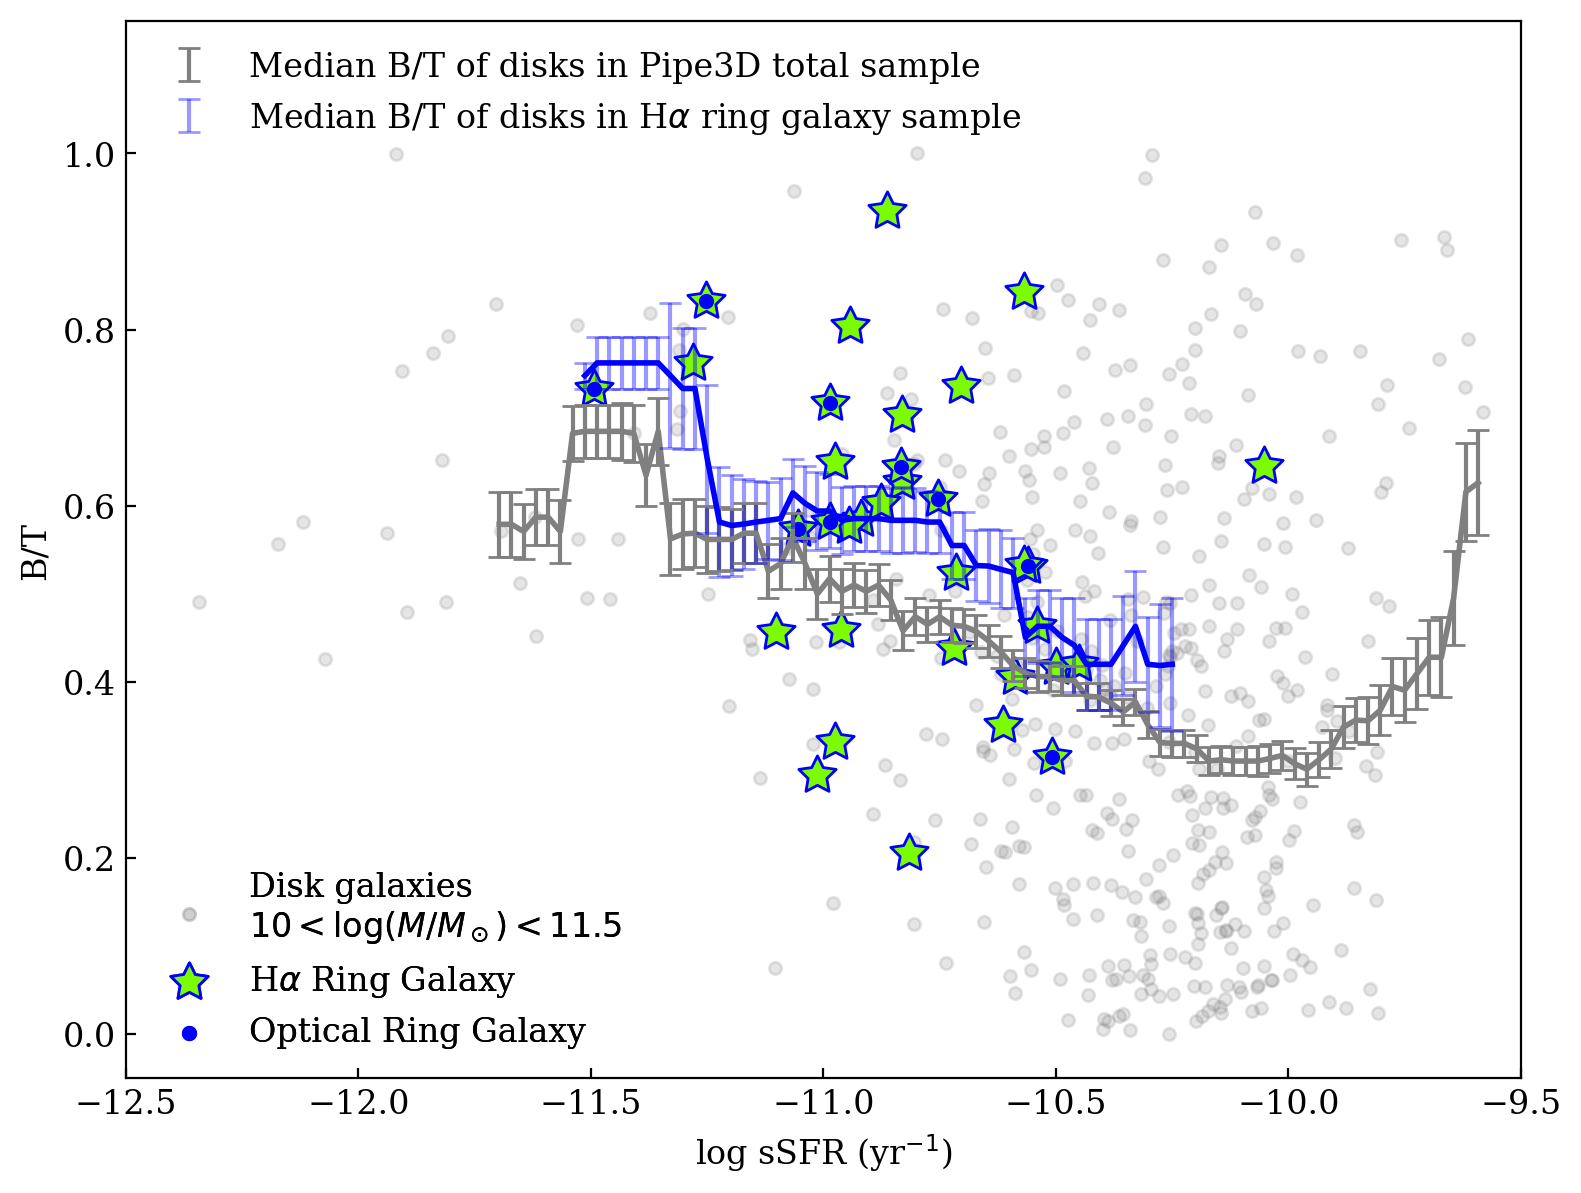

In [29]:
### 画BT radtio的median线 ###
fig = plt.figure(figsize=(9, 7))

ax = plt.subplot2grid((1, 1), (0, 0))
##############################
tot_BT = (10**all_fits[1].data['logMb'] /
          (10**all_fits[1].data['logMb'] + 10**all_fits[1].data['logMd']))
df = pd.DataFrame({
    'x': (tot_log_SSFR)[np.logical_and(bulge_mass_mask,
                                                     tdisk_mask)],
    'y':
    tot_BT[np.logical_and(bulge_mass_mask, tdisk_mask)]
})
# bin the data into equally spaced groups

#y_cut = pd.cut(df.y, np.linspace(0, 1, 21), right=False)
medianx = []
mediany = []
stdy = []
step = 19
binn = 9
for j in range(0, step):
    xrange = []
    forward = 0.5 / step * j  # 0.5与binn=9是配套的
    for i in range(binn - 1):
        xrange.append(
            (np.linspace(-13 + forward, -9 + forward, binn)[i] + np.linspace(
                -13 + forward, -9 + forward, binn)[i + 1]) / 2)
# group and count
    x_cut = pd.cut(
        df.x, np.linspace(-13 + forward, -9 + forward, binn), right=False)
    num = np.array(df.groupby([x_cut]).size())
    mask = (num > 20)
    medianx = medianx + np.array(xrange)[mask].tolist()
    mediany = mediany + df.groupby([x_cut
                                    ]).median().values[:, 1][mask].tolist()
    stdy = stdy + df.groupby([x_cut]).sem().values[:, 1][mask].tolist()
cols = ['#EE7550', '#F19463', '#F6B176']
medianx = np.array(medianx)
mediany = np.array(mediany)
stdy = np.array(stdy)

arr = np.array([medianx, mediany, stdy])
medianx = arr[0][np.argsort(arr[0])]
mediany = arr[1][np.argsort(arr[0])]
stdy = arr[2][np.argsort(arr[0])]

plt.plot(
    medianx,
    mediany,
    color='gray',
    alpha=1,
    linewidth=2,
    label='Median B/T of all disks')
err1 = plt.errorbar(
    medianx, mediany, yerr=stdy, fmt='none', capsize=4, color='gray')
#plt.fill_between(medianx, mediany-stdy, mediany+stdy, alpha=0.5,color = cols[0])
#plt.fill_between(medianx, mediany-2*stdy, mediany+2*stdy, alpha=0.5,color = cols[1])
#plt.fill_between(medianx, mediany-3*stdy, mediany+3*stdy, alpha=0.5,color = cols[2])

##############################
ring_BT = (10**ring_fits[1].data['logMb'] /
           (10**ring_fits[1].data['logMb'] + 10**ring_fits[1].data['logMd']))
df = pd.DataFrame({'x': ring_log_SSFR[rdisk_mask], 'y': ring_BT[rdisk_mask]})
# bin the data into equally spaced groups

#y_cut = pd.cut(df.y, np.linspace(0, 1, 21), right=False)
medianx = []
mediany = []
stdy = []
step = 19
binn = 9
for j in range(0, step):
    xrange = []
    forward = 0.5 / step * j
    for i in range(binn - 1):
        xrange.append(
            (np.linspace(-13 + forward, -9 + forward, binn)[i] + np.linspace(
                -13 + forward, -9 + forward, binn)[i + 1]) / 2)
# group and count
    x_cut = pd.cut(
        df.x, np.linspace(-13 + forward, -9 + forward, binn), right=False)
    num = np.array(df.groupby([x_cut]).size())
    mask = (num > 2)
    medianx = medianx + np.array(xrange)[mask].tolist()
    mediany = mediany + df.groupby([x_cut
                                    ]).median().values[:, 1][mask].tolist()
    stdy = stdy + df.groupby([x_cut]).sem().values[:, 1][mask].tolist()
cols = ['lightseagreen', 'paleturquoise', 'lightcyan']

medianx = np.array(medianx)
mediany = np.array(mediany)
stdy = np.array(stdy)

arr = np.array([medianx, mediany, stdy])
medianx = arr[0][np.argsort(arr[0])]
mediany = arr[1][np.argsort(arr[0])]
stdy = arr[2][np.argsort(arr[0])]

#plt.fill_between(medianx, mediany-3*stdy, mediany+3*stdy, alpha=0.5,color = cols[2])
#plt.fill_between(medianx, mediany-2*stdy, mediany+2*stdy, alpha=0.5,color = cols[1])
#plt.fill_between(medianx, mediany-stdy, mediany+stdy, alpha=0.5,color = cols[0])
plt.plot(
    medianx,
    mediany,
    color='blue',
    alpha=1,
    linewidth=2,
    label='Median B/T of disks in ring sample')
err2 = plt.errorbar(
    medianx,
    mediany,
    yerr=stdy,
    fmt='none',
    capsize=4,
    color='blue',
    alpha=0.4)
#plt.scatter(medianx, mediany, color='yellow', alpha=1)

sct1 = plt.scatter(
    (tot_log_SFR - tot_log_mass)[np.logical_and(bulge_mass_mask, tdisk_mask)],
    tot_BT[np.logical_and(bulge_mass_mask, tdisk_mask)],
    alpha=0.2,
    color='gray',
    s=20)
sct2 = plt.scatter(
    ring_log_SSFR[rdisk_mask],
    ring_BT[rdisk_mask],
    s=200,
    marker=(5, 1, 0),
    facecolors='lawngreen',
    edgecolors='blue')
sct3 = plt.scatter(
    ring_log_SSFR[np.logical_and(opRINGmask, rdisk_mask)],
    ring_BT[np.logical_and(opRINGmask, rdisk_mask)],
    color='blue',
    s=20)

plt.xlim(-12.5, -9.5)
plt.ylim(-0.05, 1.15)
plt.xlabel('log sSFR (yr$^{-1}$)')
plt.ylabel('B/T')
#plt.legend()
lines = ax.get_lines()
legend1 = plt.legend(
    [err1, err2], [
        'Median B/T of disks in Pipe3D total sample',
        r'Median B/T of disks in H$\alpha$ ring galaxy sample '
    ],
    loc='upper left',
    frameon=False)
legend2 = plt.legend(
    [sct1, sct2, sct3], [
        'Disk galaxies\n$10<\log(M/M_\odot)<11.5$', r'H$\alpha$ Ring Galaxy',
        'Optical Ring Galaxy'
    ],
    loc='lower left',
    frameon=False)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(direction='in')
#plt.title('moving average B/T (mass weighted), ring_bin=0.5, all_bin=0.5 ')
plt.grid('off')
plt.savefig('fig9.pdf', dpi=400, bbox_inches='tight')
plt.show()

### Bar length and ring radius

In [30]:
radius_mask=(ring_fits[1].data['validity']==1)
minimum_set=[]
for i in range(84):
    minimum_set.append(ring_fits[1].data['minimums(kpc)'][i].lstrip('[').rstrip(']').split(',')[0])
for i in range(84):
    if minimum_set[i]=='':
        minimum_set[i]=np.nan
minimum_set=np.array(minimum_set, dtype=float)
maximum_set=[]
for i in range(84):
    maximum_set.append(ring_fits[1].data['maximums(kpc)'][i].lstrip('[').rstrip(']').split(',')[0])
for i in range(84):
    if maximum_set[i]=='':
        maximum_set[i]=np.nan
maximum_set=np.array(maximum_set, dtype=float)

In [31]:
sum(~np.isnan(maximum_set)), sum(~np.isnan(minimum_set))

(71, 79)

系数k1: 3.23158344358
系数b1: 1.13428728897
系数k1: 3.07694636294
系数b1: 0.307001930465
系数k1: 1.76064559226
系数b1: 0.751591255813
系数k1: 1.61412381466
系数b1: 0.331909042179


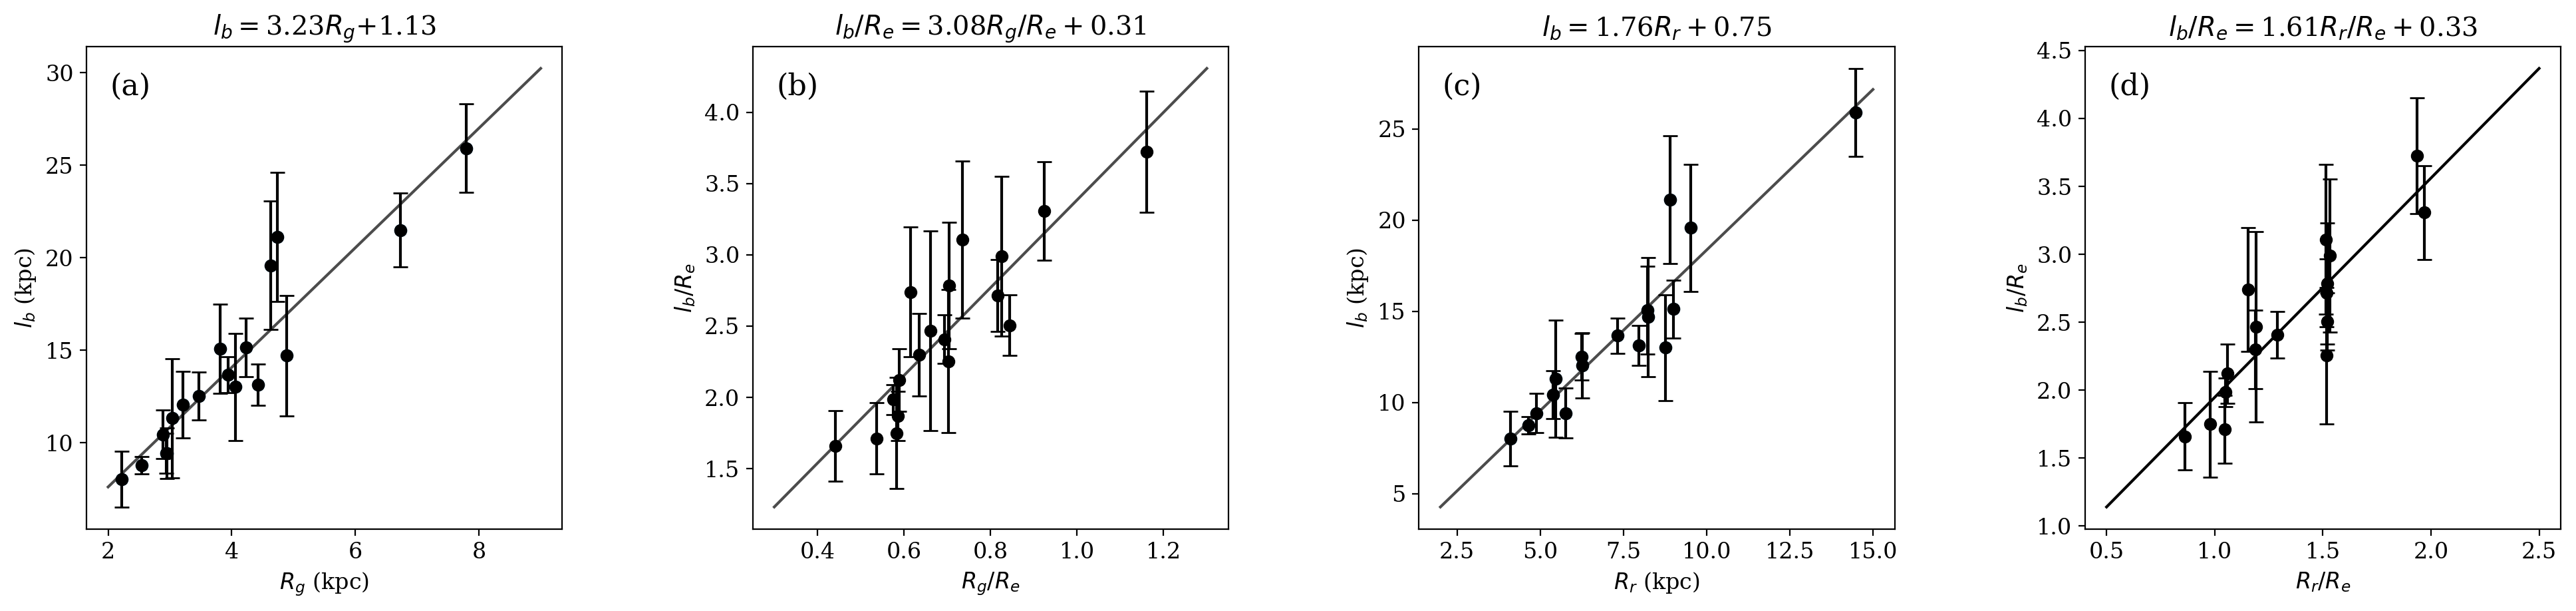

In [34]:
################## Bar length and ring radius ################
from scipy.optimize import curve_fit

h=0.7
fig=plt.figure(figsize=(24,4.8))
radlen_mask=~np.isnan(ring_fits[1].data['length_avg'][radius_mask])
ax1=plt.subplot2grid((1,4),(0,0))
x=np.linspace(2,9,10)
plt.scatter(minimum_set[radius_mask], ring_fits[1].data['length_avg'][radius_mask]/h)
plt.errorbar(minimum_set[radius_mask], ring_fits[1].data['length_avg'][radius_mask]/h, 
             yerr=ring_fits[1].data['length_stdev'][radius_mask]/h, fmt='ko',capsize=4,)

#定义线性函数
def func(x,k,b):
    return k*x+b 

popt, pcov = curve_fit(func, minimum_set[radius_mask][radlen_mask], ring_fits[1].data['length_avg'][radius_mask][radlen_mask]/h)
k=popt[0]
b=popt[1]
yvals1 = func(x,k,b) #拟合y值  
print(u'系数k1:', k ) 
print(u'系数b1:', b ) 

plt.plot(x, yvals1, 'k', alpha=0.7)
xmin, xmax=ax1.get_xlim()
ymin, ymax=ax1.get_ylim()
plt.text(0.05*(xmax-xmin)+xmin, ymin+(ymax-ymin)*0.90,'(a)',fontsize=16)
plt.xlabel(r'$R_g$ (kpc)')
plt.ylabel(r'$l_b$ (kpc)')
plt.title(r'$l_b=$'+str(round(k,2))+'$R_g$+'+str(round(b,2)))
plt.grid('off')


ax2=plt.subplot2grid((1,4),(0,1))
h=0.7
radlen_mask=~np.isnan(ring_fits[1].data['length_avg'][radius_mask])
x=np.linspace(0.3,1.3,10)
#plt.scatter(minimum_set[radius_mask]/(ring_fits[1].data['re_kpc'][radius_mask]), 
#            ring_fits[1].data['length_avg'][radius_mask]/h/(ring_fits[1].data['re_kpc'][radius_mask]),'ko')
plt.errorbar(minimum_set[radius_mask]/(ring_fits[1].data['re_kpc'][radius_mask]), 
             ring_fits[1].data['length_avg'][radius_mask]/h/(ring_fits[1].data['re_kpc'][radius_mask]),
            yerr=ring_fits[1].data['length_stdev'][radius_mask]/h/(ring_fits[1].data['re_kpc'][radius_mask]),
            fmt='ko', capsize=4)

#定义线性函数
def func(x,k,b):
    return k*x+b 
#最小二乘法拟合：
popt, pcov = curve_fit(func, minimum_set[radius_mask][radlen_mask]/(ring_fits[1].data['re_kpc'][radius_mask])[radlen_mask], 
                       ring_fits[1].data['length_avg'][radius_mask][radlen_mask]/h/(ring_fits[1].data['re_kpc'][radius_mask])[radlen_mask])
k=popt[0]
b=popt[1]
yvals1 = func(x,k,b) #拟合y值  
print(u'系数k1:', k ) 
print(u'系数b1:', b ) 


plt.plot(x, yvals1,'k', alpha=0.7)
xmin, xmax=ax2.get_xlim()
ymin, ymax=ax2.get_ylim()
plt.text(0.05*(xmax-xmin)+xmin, ymin+(ymax-ymin)*0.90,'(b)',fontsize=16)
plt.xlabel(r'$R_g/R_e$')
plt.ylabel(r'$l_b/R_e$')
plt.grid('off')
plt.title(r'$l_b/R_e=$'+str(round(k,2))+'$R_g/R_e+$'+str(round(b,2)))

##########################################################################################

ax3=plt.subplot2grid((1,4),(0,2))
x=np.linspace(2,15,10)
max_radlen_mask=np.logical_and(~np.isnan(ring_fits[1].data['length_avg']),~np.isnan(maximum_set))
plt.scatter(maximum_set[max_radlen_mask], ring_fits[1].data['length_avg'][max_radlen_mask]/h)
plt.errorbar(maximum_set[max_radlen_mask], ring_fits[1].data['length_avg'][max_radlen_mask]/h, 
             yerr=ring_fits[1].data['length_stdev'][max_radlen_mask]/h, fmt='ko', capsize=4)

#定义线性函数
def func(x,k,b):
    return k*x+b 
#最小二乘法拟合
popt, pcov = curve_fit(func, maximum_set[max_radlen_mask], ring_fits[1].data['length_avg'][max_radlen_mask]/h)
k=popt[0]
b=popt[1]
yvals1 = func(x,k,b) #拟合y值  
print(u'系数k1:', k ) 
print(u'系数b1:', b ) 

plt.plot(x, yvals1,'k', alpha=0.7)
xmin, xmax=ax3.get_xlim()
ymin, ymax=ax3.get_ylim()
plt.text(0.05*(xmax-xmin)+xmin, ymin+(ymax-ymin)*0.90,'(c)',fontsize=16)
plt.xlabel(r'$R_r$ (kpc)')
plt.ylabel(r'$l_b$ (kpc)')
plt.title(r'$l_b=$'+str(round(k,2))+'$R_r+$'+str(round(b,2)))
plt.grid('off')



ax4=plt.subplot2grid((1,4),(0,3))
h=0.7
max_radlen_mask=np.logical_and(~np.isnan(ring_fits[1].data['length_avg']),~np.isnan(maximum_set))
x=np.linspace(0.5,2.5,10)
#plt.scatter(maximum_set[max_radlen_mask]/(ring_fits[1].data['re_kpc'][max_radlen_mask]), 
#            ring_fits[1].data['length_avg'][max_radlen_mask]/h/(ring_fits[1].data['re_kpc'][max_radlen_mask]))
plt.errorbar(maximum_set[max_radlen_mask]/(ring_fits[1].data['re_kpc'][max_radlen_mask]), 
             ring_fits[1].data['length_avg'][max_radlen_mask]/h/(ring_fits[1].data['re_kpc'][max_radlen_mask]),
            yerr=ring_fits[1].data['length_stdev'][max_radlen_mask]/h/(ring_fits[1].data['re_kpc'][max_radlen_mask]),
            fmt='ko', capsize=4)

#定义线性函数
def func(x,k,b):
    return k*x+b 
#最小二乘法拟合
popt, pcov = curve_fit(func, maximum_set[max_radlen_mask]/(ring_fits[1].data['re_kpc'][max_radlen_mask]), 
                       ring_fits[1].data['length_avg'][max_radlen_mask]/h/(ring_fits[1].data['re_kpc'][max_radlen_mask]))
k=popt[0]
b=popt[1]
yvals1 = func(x,k,b) #拟合y值  
print(u'系数k1:', k ) 
print(u'系数b1:', b ) 


plt.plot(x, yvals1,'k')
xmin, xmax=ax4.get_xlim()
ymin, ymax=ax4.get_ylim()
plt.text(0.05*(xmax-xmin)+xmin, ymin+(ymax-ymin)*0.90,'(d)',fontsize=16)
plt.xlabel(r'$R_r/R_e$')
plt.ylabel(r'$l_b/R_e$')
plt.grid('off')
plt.title(r'$l_b/R_e=$'+str(round(k,2))+'$R_r/R_e+$'+str(round(b,2)))
plt.subplots_adjust(wspace=0.4)
plt.savefig('fig4.pdf', dpi=400, bbox_inches='tight')
plt.show()

### Density of the environment

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


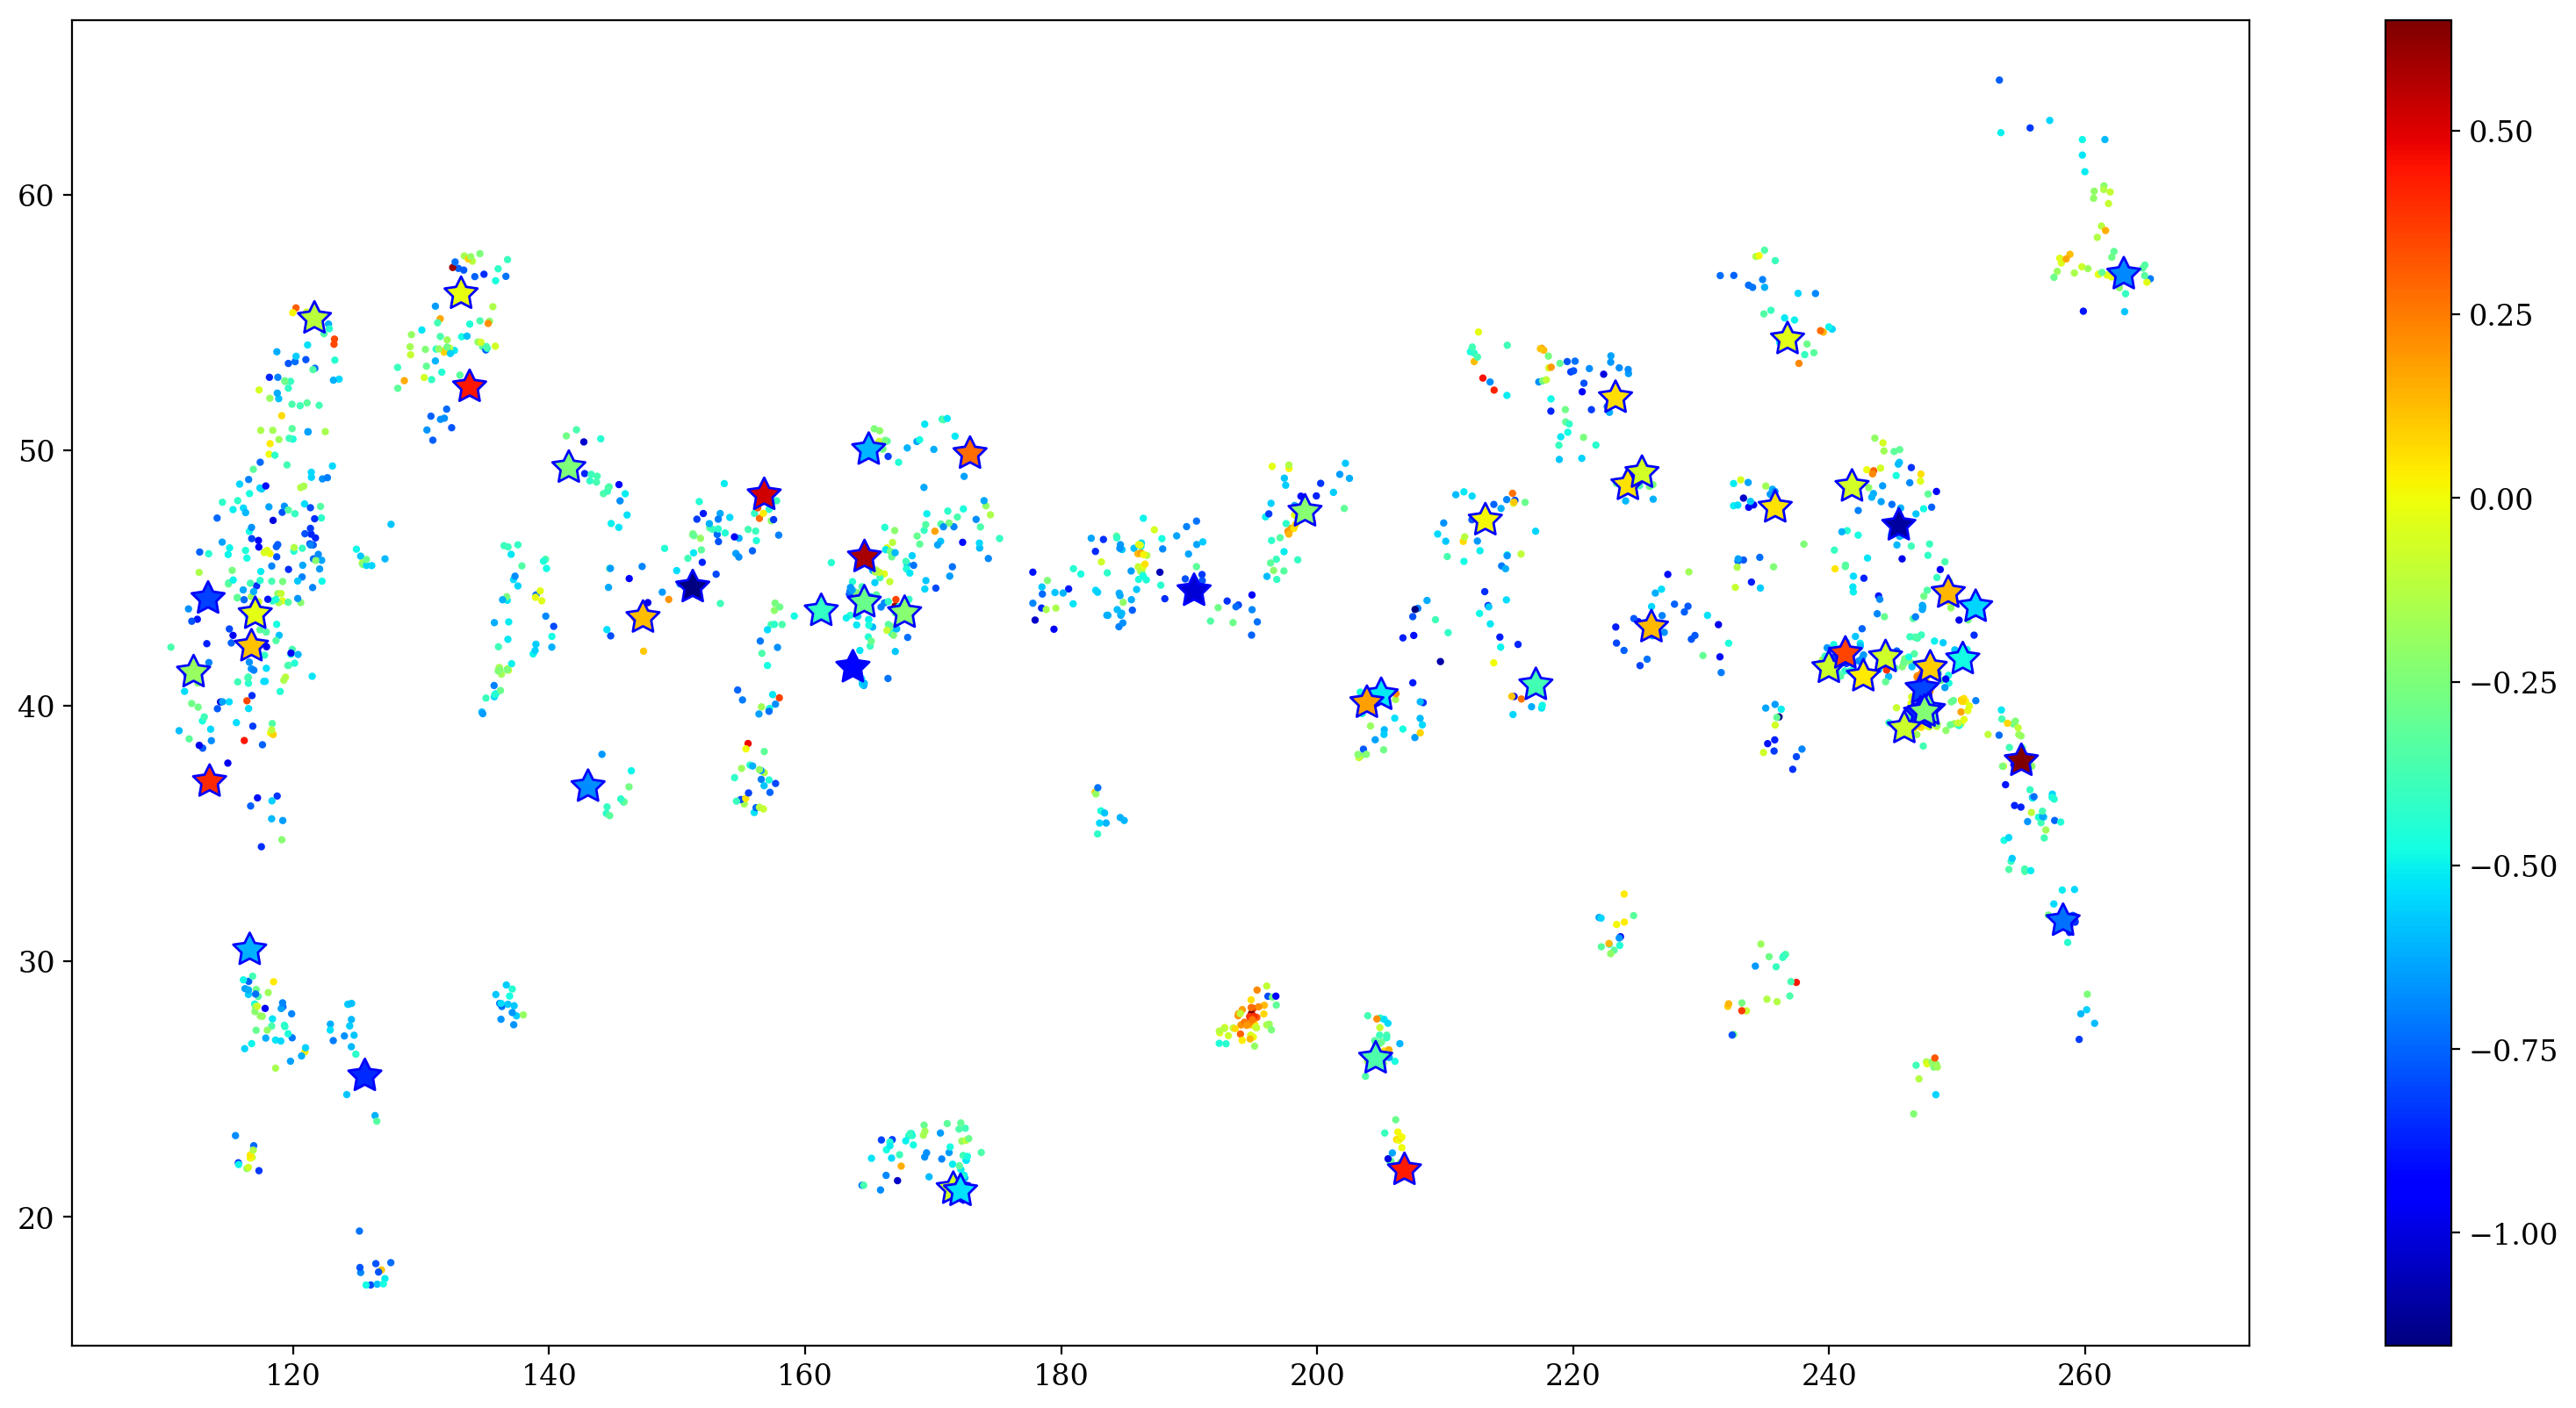

In [20]:
fig = plt.figure(figsize=(20, 10))
tmask = np.logical_and(~np.isnan(all_fits[1].data['density']), all_fits[1].data['z_2a']<0.10)
rmask = ~np.isnan(ring_fits[1].data['density'])
plt.scatter(
    all_fits[1].data['objra'][tmask],
    all_fits[1].data['objdec'][tmask],
    c=all_fits[1].data['density'][tmask],
    cmap='jet',
    s=4)
plt.scatter(
    ring_fits[1].data['objra'][rmask],
    ring_fits[1].data['objdec'][rmask],
    c=ring_fits[1].data['density'][rmask],
    s=200,
    marker=(5, 1, 0),
    edgecolors='blue',
    cmap='jet')
plt.colorbar()
plt.show()

In [101]:
sum(all_fits[1].data['density'][tmask]>0.5)/sum(tmask)

0.51383874849578826

In [100]:
sum(ring_fits[1].data['density'][rmask]>0.5)/sum(rmask)

0.5892857142857143

In [97]:
sum(rmask)

56

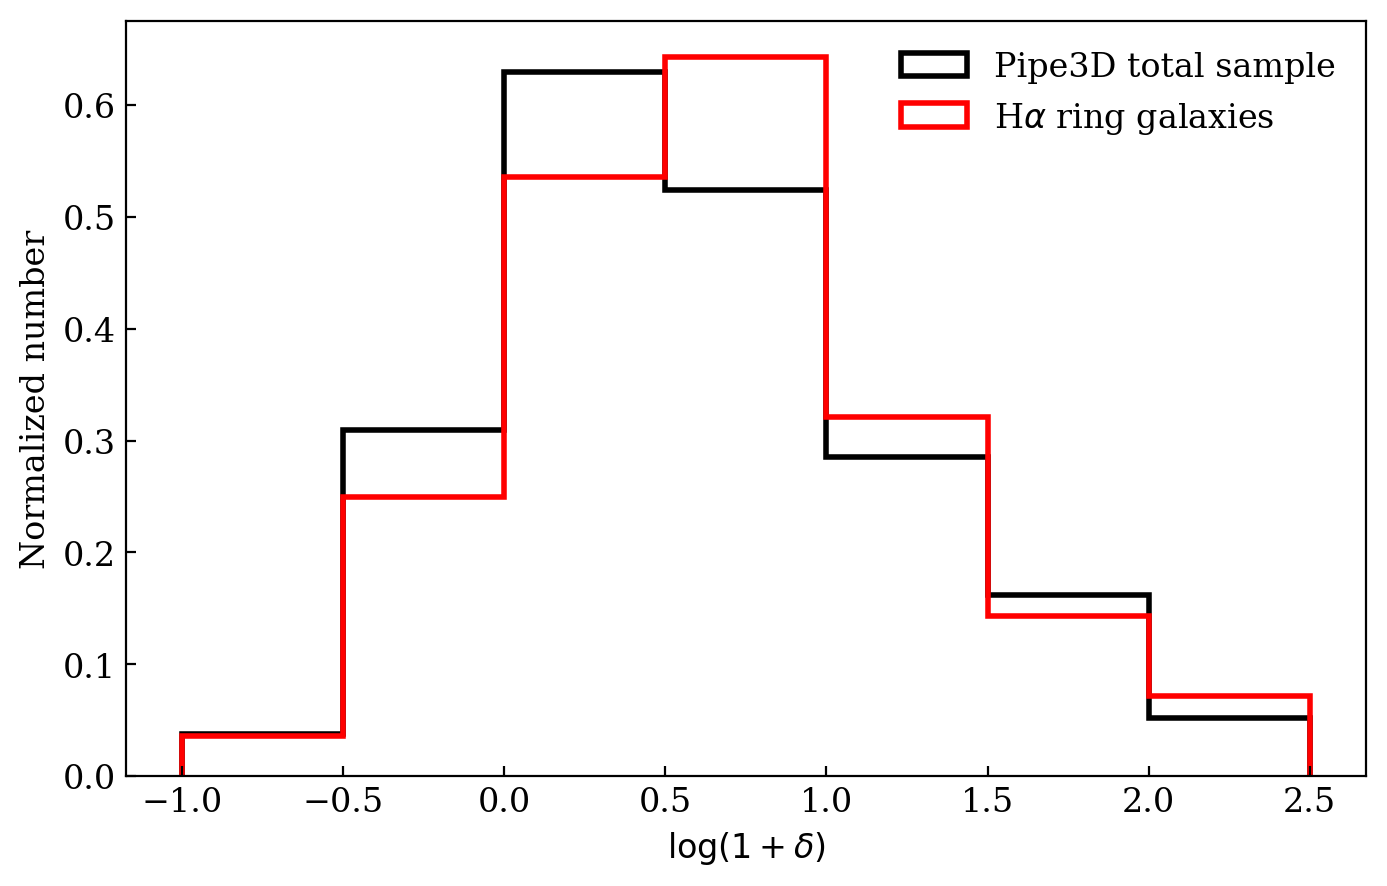

In [96]:
fig = plt.figure(figsize=(8, 5))
ax1 = plt.subplot2grid((1, 1), (0, 0))
plt.hist(
    all_fits[1].data['density'][tmask],
    edgecolor='black',
    linewidth=2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label='Pipe3D total sample')
plt.hist(
    ring_fits[1].data['density'][rmask],
    edgecolor='red',
    linewidth=2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'H$\alpha$ ring galaxies')
plt.ylabel('Normalized number')
plt.xlabel('$\log(1+\delta)$')
plt.legend(frameon=False)
ax1.tick_params(direction='in')

plt.subplots_adjust(hspace=0.4)
plt.savefig('fig9.pdf', dpi=300, bbox_inches='tight')
plt.show()

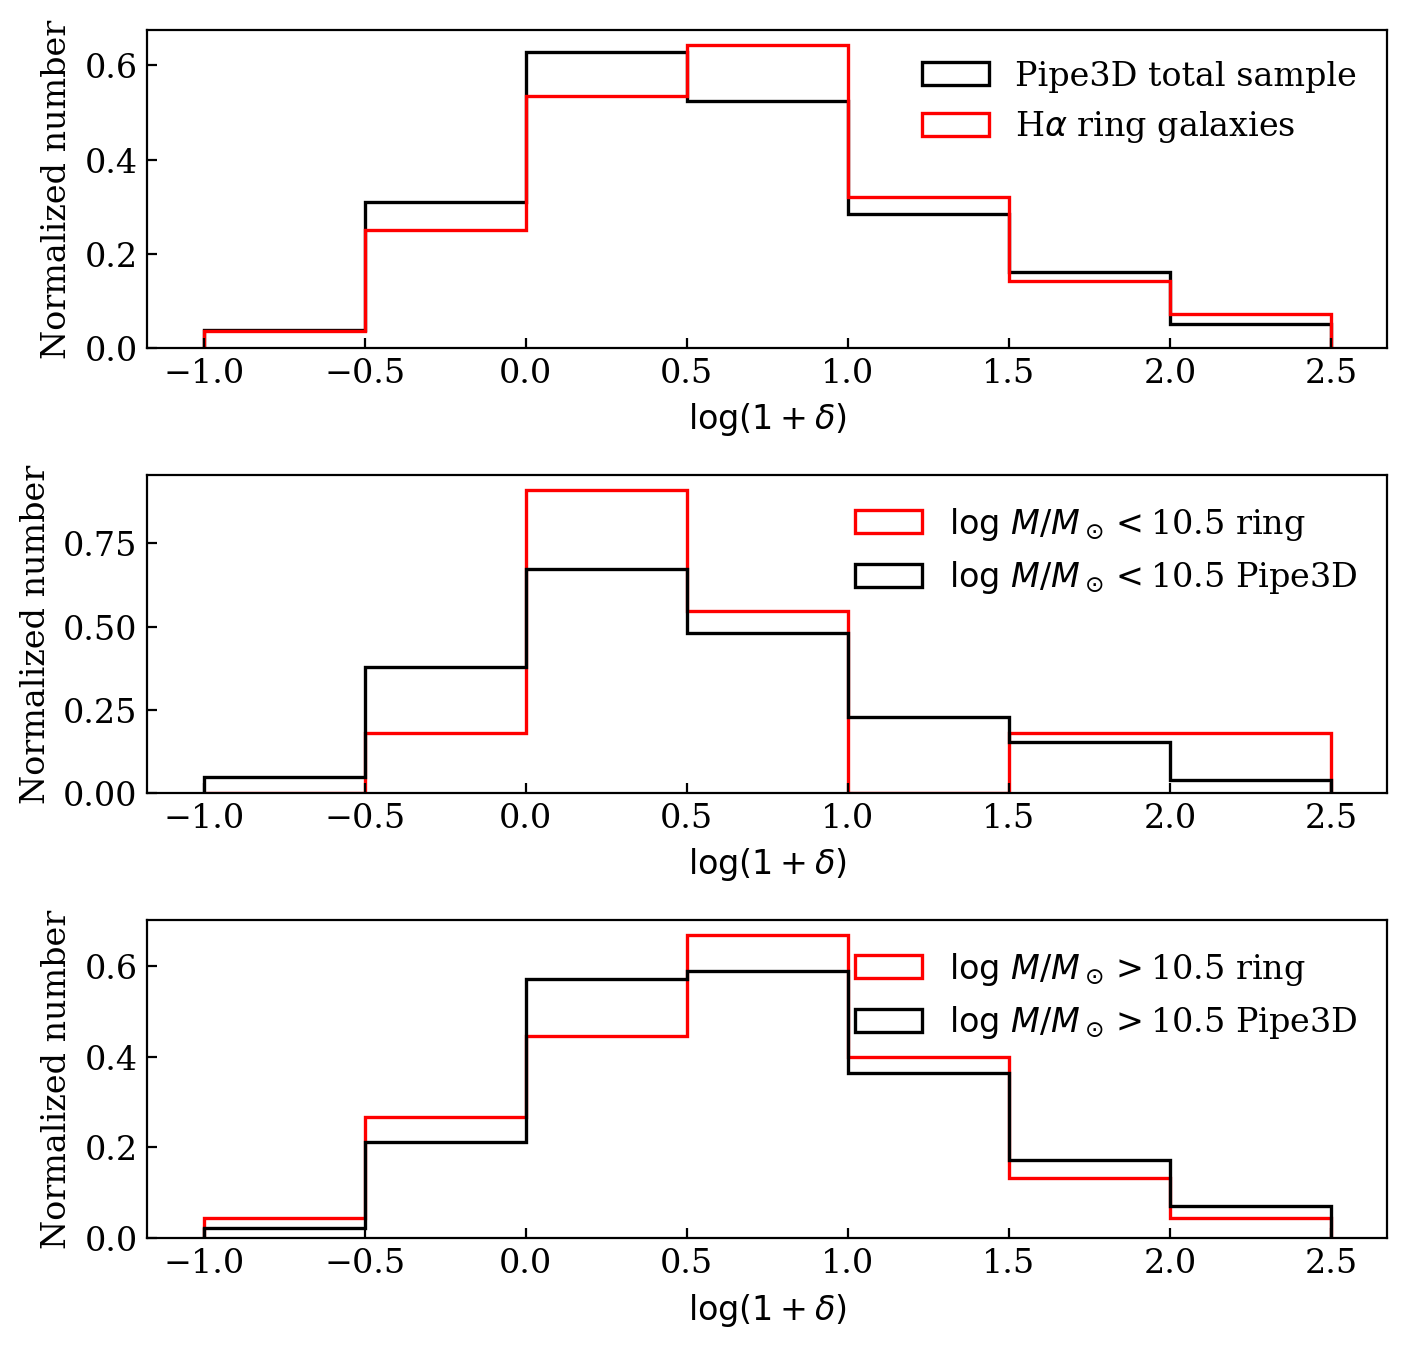

In [91]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0))
plt.hist(
    all_fits[1].data['density'][tmask],
    edgecolor='black',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label='Pipe3D total sample')
plt.hist(
    ring_fits[1].data['density'][rmask],
    edgecolor='red',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'H$\alpha$ ring galaxies')
plt.ylabel('Normalized number')
plt.xlabel('$\log(1+\delta)$')
plt.legend(frameon=False)
ax1.tick_params(direction='in')

threshold = 10.5

ax2 = plt.subplot2grid((3, 1), (1, 0))
plt.hist(
    ring_fits[1].data['density'][np.logical_and(
        rmask, ring_fits[1].data['log_mass'] < threshold)],
    edgecolor='r',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'$\log\ M/M_\odot<$'+str(threshold)+' ring')
plt.hist(
    all_fits[1].data['density'][np.logical_and(
        tmask, all_fits[1].data['log_mass'] < threshold)],
    edgecolor='k',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'$\log\ M/M_\odot<$'+str(threshold)+' Pipe3D')
plt.ylabel('Normalized number')
plt.xlabel('$\log(1+\delta)$')
plt.legend(frameon=False)
ax2.tick_params(direction='in')

ax3 = plt.subplot2grid((3, 1), (2, 0))
plt.hist(
    ring_fits[1].data['density'][np.logical_and(
        rmask, ring_fits[1].data['log_mass'] > threshold)],
    edgecolor='r',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'$\log\ M/M_\odot>$'+str(threshold)+' ring')
plt.hist(
    all_fits[1].data['density'][np.logical_and(
        tmask, all_fits[1].data['log_mass'] > threshold)],
    edgecolor='k',
    linewidth=1.2,
    bins=np.arange(-1, 3, 0.5),
    normed=1,
    histtype='step',
    label=r'$\log\ M/M_\odot>$'+str(threshold)+' Pipe3D')
plt.ylabel('Normalized number')
plt.xlabel('$\log(1+\delta)$')
plt.legend(frameon=False)
ax3.tick_params(direction='in')

plt.subplots_adjust(hspace=0.4)
plt.savefig('fig9.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
sum(np.logical_and(rmask, ring_fits[1].data['log_mass']>10.9))

17

In [92]:
sum(ring_fits[1].data['log_mass']>10.5)

72